In [1]:
import at3d
import numpy as np
import os
import sys
import xarray as xr
from collections import OrderedDict
import pylab as py
path = '/Users/khargenr/AT3D/at3d'

In [2]:
#load the cloud.
cloud_scatterer = at3d.util.load_from_csv(os.path.join(path, './data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt'),
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset(os.path.join(path, './data/ancillary/AFGL_summer_mid_lat.nc'))
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 10.0]})
#merge the atmosphere and cloud z coordinates
#merged_z_coordinate = at3d.grid.combine_z_coordinates([aerosol_scatterer, cloud_scatterer])

#make a merged grid for the rte.
rte_grid = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

In [3]:

# rte_grid = at3d.grid.make_grid(0.1, 10, 0.1, 10, merged_z_coordinate)
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


# Reconstruction MODIS + MISR

In [4]:
#define sensors.
sensor_resolution = 0.02
sensors_dict = at3d.containers.SensorsDict()
sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90]*4 + [-90]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list, sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    at3d.sensor.orthographic_projection(0.66, 
                                                           rte_grid, 
                                                           sensor_resolution, 
                                                           sensor_resolution,
                                                           azimuth, zenith,
                                                           altitude='TOA', stokes=['I'])
                           )
for wavelength in [1.64, 2.13]:
    sensors_dict.add_sensor('MODIS',
    at3d.sensor.orthographic_projection(wavelength, 
                                           rte_grid, 
                                           sensor_resolution, 
                                           sensor_resolution,
                                           azimuth, zenith,
                                           altitude='TOA', stokes=['I'])
                         )
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()

In [5]:
#rayleigh optical properties if desired.
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths, atmosphere, rte_grid)

In [6]:
solvers = at3d.containers.SolversDict()
cloud_poly_tables = OrderedDict()

for wavelength in wavelengths:
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
    # print(wavelength)
    # #optical properties from mie calculations.
    # # Cloud
    # water_file = './mie_tables/mie_table_water_SWIR_%d.nc'%(wavelength*1e3)
    # try:
    #     mie_mono_table = xr.load_dataset(water_file)
    # except IOError:
    #     mie_mono_table = at3d.mie.get_mono_table(
    #         'Water', 
    #         (wavelength, wavelength),
    #         minimum_effective_radius=0.1,
    #     )
    #     mie_mono_table.to_netcdf(water_file, mode='w')
    cloud_size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_table.radius.data,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0,
        reff={'coord_min':.1,'coord_max':30.0,'npoints':30,'spacing':'linear','units':'micron'},
        veff={'coord_min':0.09,'coord_max':0.11,'npoints':2,'spacing':'linear','units':'unitless'},
    )
    poly_table = at3d.mie.get_poly_table(cloud_size_distribution, mie_mono_table)
    cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    cloud_poly_tables[wavelength] = poly_table

    # Define solvers
    config = at3d.configuration.get_config()
    config['num_mu_bins'] = 8
    config['num_phi_bins'] = 16
    config['split_accuracy'] = 0.03
    config['spherical_harmonics_accuracy'] = 0 #.001
    config['solution_accuracy'] = 1e-4
    solvers.add_solver(
        wavelength, 
        at3d.solver.RTE(
            numerical_params=config,
            medium={
                'cloud': cloud_optical_scatterer,
                'rayleigh': rayleigh_scatterer_list[wavelength]
            },
            source=at3d.source.solar(wavelength, np.cos(np.deg2rad(60.0)), 0.0, solarflux=1.0),
            surface=at3d.surface.ocean_unpolarized(10.0, 0.0, delx=10.0, dely=10.0),
            num_stokes=min_stokes[wavelength],
            name=None
        )
    )

In [7]:
# get total OD
for wvl in wavelengths:
    sensor_od = sensors_dict['MISR']['sensor_list'][-1]
    solvers[wvl].optical_path(sensor_od)
    print('cloud OD @ %.3f nm ='%wvl, sensor_od.optical_path.data.mean())
    # get Rayleigh OD

cloud OD @ 0.660 nm = 3.301307
cloud OD @ 1.640 nm = 3.3963447
cloud OD @ 2.130 nm = 3.4415367


In [8]:
#very important for the retrieval. the unknowns are visible extinction
#and reff not LWC and Reff. Much more orthogonal.
scaling_factor = cloud_poly_tables[0.66].extinction[:].copy(deep=True).data
#print(scaling_factor)
for wavelength in cloud_poly_tables:
    cloud_poly_tables[wavelength]['extinction'][:] /= scaling_factor

In [9]:
sensors_dict.get_measurements(solvers, n_jobs=8)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.555  0.272E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     1  -0.607  0.324E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     1  -0.652  0.355E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     2  -1.012  0.321E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     2  -1.110  0.370E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     2  -1.309  0.397E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     3  -1.431  0.349E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     3  -1.482  0.393E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     3  -1.637  0.413E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     4  -1.671  0.293E+00    30817    16.10  0.252   [Radiance 2.130 micron]
     4  

In [10]:
def retrieve(uncertainty = 6e9, scale = 1.5e2):
    Sensordict = sensors_dict
    uncertainty = at3d.uncertainties.NullUncertainty('L2', uncertainty)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
                #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    Sensordict.add_uncertainty_model('MISR', uncertainty)
    # uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(0, .001)
    # Sensordict.add_uncertainty_model('MISR', uncertainty)
    # Sensordict.add_noise('MISR')
    # Sensordict.add_uncertainty_model('MODIS', uncertainty)
    # Sensordict.add_noise('MODIS')
    forward_sensors = Sensordict.make_forward_sensors() # make a perfect copy of the sensor with the same subpixel rays.

    scale_reff = scale
    #scale_aerosol_density = 1e4

    wavelengths = forward_sensors.get_unique_solvers()

    mask = solvers[0.66].medium['cloud'].extinction.data > 0.0

    ext_profile = np.sum(solvers[0.66].medium['cloud'].extinction.data, axis=(0,1))
    CBH = rte_grid.z.data[np.where(ext_profile>0)[0][0]]
    CTH = rte_grid.z.data[np.where(ext_profile>0)[0][-1]]
    print(CBH, CTH)
    initial_cloud = xr.Dataset(
        data_vars={
            'density':(['x','y','z'], np.ones((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))),
            'reff': (['x','y','z'], np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+10.0),
            'veff':(['x','y','z'] ,np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+0.1)
        },
        coords=rte_grid.coords
    )

    #resample the cloud onto the rte_grid
    initial_cloud_on_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer_on_rte_grid.copy(deep=True))
    reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))

    def state_to_grid_density_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[mask] = state[1:]
        return state_on_grid

    def state_to_grid_reff_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
        state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
        state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
        return state_on_grid

    solvers_reconstruct = at3d.containers.SolversDict()
    rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

    def set_state_fn(state):

        #update microphysics
        #aerosol_scatterer_on_rte_grid = initial_aerosol_on_grid.copy(deep=True)
        cloud_scatterer_on_rte_grid = initial_cloud_on_grid.copy(deep=True)

        cloud_scatterer_on_rte_grid['density'][:] = state_to_grid_density_cloud(state)
        cloud_scatterer_on_rte_grid['reff'][:] = state_to_grid_reff_cloud(state)
        #update optical properties
        for wavelength in wavelengths:
            poly_table = cloud_poly_tables[wavelength] #tables are used here.
            cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
            #cloud_optical_scatterer['extinction'][:] = state_to_grid_ext_cloud(state)
            
            #aerosol_poly_table = aerosol_poly_tables[wavelength]
            #aerosol_optical_scatterer = at3d.medium.table_to_grid(aerosol_scatterer_on_rte_grid, aerosol_poly_table)
            #aerosol_optical_scatterer['extinction'][:] = state_to_grid_ext_aerosol(state)      

    #         config = at3d.configuration.get_config('./default_config.json')
    #         config['num_mu_bins'] = 2
    #         config['num_phi_bins'] = 4
    #         config['split_accuracy'] = 0.1
    #         config['spherical_harmonics_accuracy'] = 0.001
    #         config['solution_accuracy'] = 1e-5
            solvers_reconstruct.add_solver(wavelength, at3d.solver.RTE(#numerical_params=config,
                                    numerical_params=solvers[wavelength].numerical_params,#config,
                                                    medium={'cloud': cloud_optical_scatterer,
                                                        'rayleigh': rayleigh_scatterer_list[wavelength]
                                                        },
                                                    source=solvers[wavelength].source,
                                                    surface=solvers[wavelength].surface,
                                                    num_stokes=solvers[wavelength]._nstokes,
                                                    name=None
                                                    )
                                    )

    # unknown_scatterers = at3d.containers.UnknownScatterers()
    # unknown_scatterers.add_unknown('cloud', ['density','reff'], cloud_poly_tables)
    # unknown_scatterers.create_derivative_tables()

    mie_mono_tables = OrderedDict()
    for wavelength in wavelengths:
        mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
            'Water',(wavelength,wavelength),
            max_integration_radius=65.0,
            minimum_effective_radius=0.1,
            relative_dir='../mie_tables',
            verbose=False
        )

    optical_property_generator = at3d.medium.OpticalPropertyGenerator(
        'cloud', 
        mie_mono_tables,
        at3d.size_distribution.gamma,
        density_normalization='geometric_extinction',
        reff=np.linspace(.1,30.0,30),
        veff=np.linspace(0.03,0.2,9),
    )

    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, cloud_optical_scatterer
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
            reff=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridProfile(mask=mask)),
            density=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridMask(mask=mask))
        #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
        )
    )

    def project_gradient_to_state(state, gradient):
        cloud_gradient = gradient.gradient.sel(variable_name='density',
                                            scatterer_name='cloud').data[mask]

        reff_gradient = gradient.gradient.sel(variable_name='reff',
                                            scatterer_name='cloud').where(mask, np.nan)
        
        reff_gradient1 = np.nansum(reff_gradient, axis=(0,1))*(rte_grid.z.data - 0.44)**(1.0/3)
        #reff_gradient2 = np.nansum(reff_gradient,axis=(0,1))

        full_grad = np.append(np.nansum(reff_gradient1)/scale_reff, cloud_gradient)
        
        #print some things here because I'm lazy.
        print('reff', state[0]/scale_reff , full_grad[0])
        print('cloud density avg.', np.mean(state[1:]), np.mean(full_grad[1:]))
        print('reff profile retrieve', state_to_grid_reff_cloud(state).mean(axis=(0,1)))
        print('reff profile true', reff_profile_true)
        return full_grad

    min_bound = np.zeros(1+np.sum(mask))+1e-5
    min_bound[0] = 1e-4*scale_reff

    max_bound = np.zeros(1+np.sum(mask))+199
    max_bound[0] = 29.9*scale_reff

    obj_fun = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        Sensordict, 
        solvers_reconstruct,
        forward_sensors,
        unknown_scatterers,
        set_state_fn,
        project_gradient_to_state,
        #exact_single_scatter=False,
        parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                    'verbose':False, 'maxiter':100, 'init_solution':True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':False},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bound,
        max_bounds=max_bound
    )

    # initial guess
    x0_reff = 10
    x0_ext_cloud = 10
    x0 = np.append(np.array([x0_reff*scale_reff]), x0_ext_cloud*np.ones(np.sum(mask)))
    print(x0)
    print(state_to_grid_reff_cloud(x0).mean(axis=(0,1)))
    optimizer = at3d.optimize.Optimizer
    optimizer = at3d.optimize.Optimizer
    optimizer.options

    #define optimizer (no prior function)
    optimizer = at3d.optimize.Optimizer(obj_fun)#, prior_fn=prior_func)
    optimizer._options['maxls'] = 8
    optimizer._options['maxiter'] = 20 #maxiter to 1 to debug the saving of result.
    #optimize for the specified initial condition.
    result = optimizer.minimize(x0)
    return solvers_reconstruct[.66].medium['cloud'].reff.data.max(), np.nanmean(solvers_reconstruct[.66].medium['cloud'].density.data[mask])

In [11]:
uncertainties = np.exp(np.arange(0, 3, .6))*4.14440598e+09
print(uncertainties)
scales = np.exp(np.arange(-.5, 2.5, .5))*15.03882656
print(scales)

[4.14440598e+09 7.55160005e+09 1.37599124e+10 2.50721951e+10
 4.56845181e+10]
[  9.12150939  15.03882656  24.79483324  40.87976896  67.39934462
 111.12273311]


1 out of 30
------uncertainty 4144405980.0 scale 9.121509394740674 -------
0.56 1.4


/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/gradient.py:110: UserWarning: No uncertainty model supplied for instrument 'MODIS'. Using at3d.uncertainties.NullUncertainty which isequivalent to unweighted least squares.
  warnings.warn(


[91.21509395 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1985.4241455232461
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698   

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[150.3882656  10.         10.        ...  10.         10.
  10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1204.2206167936058
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698  

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[247.94833236  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 730.3967251433801
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[408.79768959  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 443.0080075531614
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.899999999999995 7.869273200893019
cloud density avg. 23.256078770205804 -0.8159919330860456
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 19.417882230114806 8.708617390589371
cloud density avg. 23.267197662797074 -0.43446550264303874
reff profile retrieve [ 4.1         6.64082231  8.36691182  9.57772312 10.54164832 11.35564642
 12.06717497 12.70343608 13.28164462 13.81346706 14.30721795 14.7690566
 15.20368776 15.61479585 16.00532652 16.37767616 16.73382363 17.07542415
 17.40387792 17.


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[673.99344625  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 268.69793907919825
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 5.961877596517137
cloud density avg. 22.94925750647158 -1.1497306651451795
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 16.559856482326715 7.114199977082331
cloud density avg. 23.018180364200894 -0.6711992680687384
reff profile retrieve [ 4.1         5.66339125  7.13542585  8.1680236   8.99007323  9.68426282
 10.29106487 10.83367773 11.32678251 11.78032853 12.20140658 12.59526939
 12.96592926 13.3165283  13.64957862 13.96712389 14.27085171 14.56217367
 14.84228389 15.11220256 15.372


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[1111.22733114   10.           10.         ...   10.           10.
   10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 162.97353825313107
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.5


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 10.014976492007007 -0.5181596943899668
cloud density avg. 22.158638109609438 0.008186756680230316
reff profile retrieve [ 4.1         4.1         4.31532255  4.93981119  5.43696572  5.85679378
  6.2237721   6.55193044  6.85014756  7.12444057  7.37909777  7.6172959
  7.84146148  8.05349479  8.25491508  8.44695832  8.63064511  8.80682916
  8.97623264  9.13947253  9.29708061  9.44951886  9.59719145  9.74045423
  9.87962238 10.01497649]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   12    f=  3.99992D+03    |proj g|=  1.38910D+00
reff 10.031185775635764 0.46616539686621944
cloud density avg. 22.155691404854462 -0.09494620135584193
reff profile retrieve [ 4.1         4.1         4.32230692  4.9478063   5.44576548  5.86627303
  6.2338453   6.56253477  6.86123456  7.1359715   7.39104087  7.62962453
  7.85415292  8.06652

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[91.21509395 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 3617.678662283775
cloud density avg. 10.0 -28.879559463152813
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '73'. Max cell optical depth: '2.5242717266082764'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '196'. Max cell optical depth: '3.0090878009796143'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -8984.067625472071
cloud density avg. 38.87971021346577 7.0665465940747865
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    1    f=  2.83825D+06    |proj g|=  2.72732D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.3603148460388184'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '61'. Max cell optical depth: '2.477473735809326'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '73'. Max cell optical depth: '2.5278961658477783'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.900000000000002 -322.73856841418683
cloud density avg. 49.29768002512441 3.4135382734622164
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    2    f=  2.76050D+06    |proj g|=  9.10113D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '2.302818775177002'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '53'. Max cell optical depth: '2.417121171951294'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '60'. Max cell optical depth: '2.466315507888794'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.900000000000002 -320.8416189704418
cloud density avg. 48.18325194806669 3.4870405139372758
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7'. Max cell optical depth: '2.0728342533111572'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '16'. Max cell optical depth: '2.175710678100586'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '24'. Max cell optical depth: '2.21999192237854'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.900000000000002 -286.18780537835835
cloud density avg. 43.72553963983582 nan
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 29.900000000000002 -228.08563140787078
cloud density avg. 38.140579199760985 2.8930651053343994
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.149728776713776 -17.09228415379864
cloud density avg. 25.60021297997178 0.38372731217161077
reff profile retrieve [ 4.1         9.96906701 12.56023738 14.37788261 15.82490746 17.0468648
 18.11499696 19.07013915 19.93813402 20.73649502 21.4777038  22.17100656
 22.82346599 23.44061307 24.02686974 24.58583343 25.12047475 25.63327848
 26.12634658 26.60147485 27.06021112 27.5039     27.93371786 28.3507005
 28.75576523 29.14972878]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   10    f=  3.69530D+04    |proj g|=  8.46745D+00
reff 29.900000000000002 -8.327845343132077
cloud density avg. 25.50461006141789 0.23742406525138698
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[150.3882656  10.         10.        ...  10.         10.
  10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 2194.233025663295
cloud density avg. 10.0 -28.879559463152813
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698   

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '73'. Max cell optical depth: '2.5242717266082764'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '196'. Max cell optical depth: '3.0090878009796143'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -5449.112450758783
cloud density avg. 38.87971021346577 7.066546521943358
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    1    f=  2.83825D+06    |proj g|=  4.49659D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '2.3104116916656494'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '53'. Max cell optical depth: '2.425091505050659'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '60'. Max cell optical depth: '2.4744479656219482'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -186.58955815086773
cloud density avg. 47.97488287952414 3.299216550303936
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    2    f=  2.54657D+06    |proj g|=  5.12396D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '27'. Max cell optical depth: '2.2532777786254883'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '43'. Max cell optical depth: '2.365118980407715'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '52'. Max cell optical depth: '2.413255453109741'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -177.99924534706813
cloud density avg. 46.70266090689515 3.2218051675425605
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.1067092418670654'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '23'. Max cell optical depth: '2.211268663406372'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '27'. Max cell optical depth: '2.2562735080718994'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -153.67750214276194
cloud density avg. 43.43895241651605 2.8980729042149833
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    3    f=  1.83611D+06    |proj g|=  4.22275D+01
reff 29.9 186.33162454504838
cloud density avg. 5.351727649060257 -37.023025508212136
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.767

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.014498472213745'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.0554986000061035'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -137.30473198783227
cloud density avg. 40.0428506748077 2.6828257018463098
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 29.9 60.811695498260754
cloud density avg. 22.69728916193398 -3.7263861072285995
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.005629777908325'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -94.98757337448075
cloud density avg. 37.81395392393104 1.5837085827094777
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 29.9 51.37159714975398
cloud density avg. 23.21458151653713 -3.2885442097414685
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 0.17414882996432818
cloud density avg. 25.31776182523885 -0.019632204463583987
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    8    f=  4.15322D+04    |proj g|=  1.40035D+01
reff 29.80603302234079 3.5952721387237916
cloud density avg. 25.12752269465762 nan
reff profile retrieve [ 4.1        10.19351991 12.8430303  14.70159971 16.18120422 17.43067385
 18.52285494 19.49950209 20.38703981 21.20337586 21.9612729  22.67018533
 23.33733484 23.96837695 24.56783315 25.13938187 25.686


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.88842005197217 -1.5839736600672731
cloud density avg. 25.348287612381927 0.08265742637447268
reff profile retrieve [ 4.1        10.22169587 12.8785298  14.74223648 16.22593078 17.47885408
 18.57405407 19.55340078 20.44339175 21.26198423 22.02197618 22.73284812
 23.4018417  24.03462808 24.63574124 25.20886979 25.7570596  26.28285843
 26.7884215  27.27559012 27.74595135 28.20088387 28.64159387 29.06914338
 29.48447297 29.88842005]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    9    f=  3.62209D+04    |proj g|=  1.49308D+01
reff 29.9 -2.767084534481871
cloud density avg. 25.327245393110182 0.12500629891647796
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 2

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[247.94833236  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1330.869604618806
cloud density avg. 10.0 -28.879559463152813
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '73'. Max cell optical depth: '2.5242717266082764'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '196'. Max cell optical depth: '3.0090878009796143'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -3305.053843861481
cloud density avg. 38.87971021346577 7.0665467378086975
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    1    f=  2.83825D+06    |proj g|=  7.41363D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '24'. Max cell optical depth: '2.215420961380005'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '38'. Max cell optical depth: '2.3404245376586914'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '45'. Max cell optical depth: '2.3946633338928223'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 26.335849023175157 -134.84270606426603
cloud density avg. 45.26277079203252 2.854755819537092
reff profile retrieve [ 4.1         9.00673367 11.34777335 12.98995777 14.29729851 15.40129794
 16.36632123 17.2292617  18.01346735 18.73476101 19.40441947 20.03079637
 20.62027263 21.17784531 21.70750949 22.21251533 22.69554669 23.15884849
 23.60431976 24.03358298 24.44803655 24.84889528 25.23722199 25.61395249
 25.97991554 26.33584902]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    2    f=  2.16880D+06    |proj g|=  8.83725D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '15'. Max cell optical depth: '2.1808624267578125'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '2.2995800971984863'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '40'. Max cell optical depth: '2.350085973739624'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 27.049711669383992 -95.6993038191467
cloud density avg. 44.10556208342126 2.655458975823502
reff profile retrieve [ 4.1         9.25087126 11.65536744 13.34206511 14.68484278 15.81876735
 16.80994868 17.69628011 18.50174253 19.24258767 19.93039796 20.57375351
 21.17920818 21.75189449 22.29591581 22.81461041 23.31073487 23.78659498
 24.24414125 24.68504013 25.11072793 25.52245238 25.92130512 26.30824732
 26.68413021 27.04971167]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    3    f=  1.93979D+06    |proj g|=  7.06724D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.0236222743988037'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -12.704101174119838
cloud density avg. 34.50659968891919 -3.7150896562196234
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.038041591644287'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '11'. Max cell optical depth: '2.1446011066436768'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '18'. Max cell optical depth: '2.1906778812408447'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 28.426776769511118 -45.47321068558896
cloud density avg. 39.46799753638303 1.3225880322541337
reff profile retrieve [ 4.1         9.7218209  12.2487268  14.02129202 15.43242873 16.6240799
 17.66572096 18.59717436 19.44364181 20.22220239 20.9450282  21.62113613
 22.2574137  22.85925472 23.43097144 23.9760721  24.4974536  24.99753912
 25.47837847 25.94172293 26.38908193 26.82176673 27.24092454 27.64756545
 28.04258404 28.42677677]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    4    f=  1.23892D+06    |proj g|=  3.65283D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0091075897216797'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 7.323698538826539
cloud density avg. 31.889628519185052 -4.6114875914554485
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.0296623706817627'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.0727734565734863'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.053513841575704 -21.734613218033097
cloud density avg. 36.24401578632096 -0.08483435203967318
reff profile retrieve [ 4.1         9.93616197 12.51877962 14.33042533 15.77267396 16.99059797
 18.05520452 19.00719406 19.87232393 20.66804977 21.40681203 22.09782639
 22.74813224 23.3632423  23.9475639  24.50468262 25.03755924 25.54867035
 26.04011097 26.51367097 26.97089308 27.41311747 27.84151663 28.25712292
 28.66085066 29.05351384]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    5    f=  8.77762D+05    |proj g|=  3.66388D+01
reff 29.838792818549557 66377.29006402448
cloud density avg. 31.218796210593137 -3683.6326786307714
reff profile retrieve [ 4.1        10.2047236  12.85714607 14.71775823 16.19898898 17.4498319
 18.5432134  19.52093399 20.4094472  21.22668048 21.98541052 22.69510212
 23.36298489 23.99472058 

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.0293986797332764'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.0725066661834717'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.05458360616119 91636.11980123908
cloud density avg. 36.23717006385284 -3393.4991959687873
reff profile retrieve [ 4.1         9.93652782 12.51924057 14.33095298 15.77325472 16.99122357
 18.05586933 19.00789392 19.87305564 20.66881078 21.40760024 22.09864004
 22.74896984 23.36410254 23.94844566 24.50558489 25.03848113 25.54961106
 26.04106978 26.51464722 26.97188617 27.41412684 27.84254177 28.25816337
 28.66190596 29.05458361]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.035757303237915'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.446688212355372 -1.1701981229981508
cloud density avg. 33.72798313722299 -1.294256926549011
reff profile retrieve [ 4.1        10.07062571 12.68819332 14.5243556  15.98612185 17.22052773
 18.29954136 19.26441395 20.14125142 20.94774563 21.69650538 22.39687108
 23.05597736 23.67941156 24.27164065 24.83629872 25.37638664 25.8944145
 26.39250567 26.87247425 27.33588384 27.78409274 28.21828933 28.63951992
 29.04871121 29.44668821]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    6    f=  6.76281D+05    |proj g|=  2.55693D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 36783.25455480047
cloud density avg. 32.748951400365435 -1077.4191668201443
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    7    f=  5.37880D+05    |proj g|=  7.41363D+02
  ys=-3.294E+07  -gs= 4.733E+04 BFGS update SKIPPED


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0055630207061768'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '52'. Max cell optical depth: '2.555781126022339'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '135'. Max cell optical depth: '3.0466485023498535'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -1546.5957374934276
cloud density avg. 31.251635212088658 0.9097069908411022
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0155234336853027'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.076672077178955'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 19.976219759771812 -38.483412447034596
cloud density avg. 32.25199198569867 -0.30714528323565216
reff profile retrieve [ 4.1         6.83177106  8.60749217  9.85311887 10.84476057 11.68216418
 12.41415188 13.06870789 13.66354212 14.21065646 14.71860456 15.19372282
 15.64085127 16.06378027 16.46554017 16.84859627 17.21498433 17.56640716
 17.90430521 18.22990916 18.54427971 18.84833834 19.14289121 19.42864813
 19.70623775 19.97621976]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0347347259521484'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 26.594996958362167 217650.88993683553
cloud density avg. 32.58344467437143 -5045.570759327217
reff profile retrieve [ 4.1         9.09536102 11.45943681 13.11778052 14.43798565 15.55284857
 16.52736781 17.39879971 18.19072204 18.91911332 19.5953613  20.22790183
 20.8231786  21.38623786 21.921114   22.43108917 22.91887361 23.38673435
 23.83658912 24.27007634 24.68860818 25.09341141 25.4855593  25.86599688
 26.23556105 26.59499696]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0293941497802734'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 28.111239010634527 -13.267948222335711
cloud density avg. 32.65937448584951 -1.0451705295001592
reff profile retrieve [ 4.1         9.61390851 12.1127657  13.86565541 15.26112848 16.4395523
 17.46963113 18.39074537 19.22781702 19.99773556 20.712538   21.38114111
 22.01035599 22.60551656 23.17088722 23.70993724 24.2255314  24.72006596
 25.19556799 25.65376931 26.09616262 26.52404461 26.93854976 27.34067695
 27.73131083 28.11123901]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.027909517288208'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.304674655016473 -6.164656497956513
cloud density avg. 32.71913891683422 -1.1888937242830517
reff profile retrieve [ 4.1        10.02205776 12.62700153 14.45430849 15.90902503 17.1374777
 18.21128753 19.1715068  20.04411551 20.84672021 21.5918689  22.28885692
 22.94478451 23.56521205 24.15458497 24.71651985 25.25400306 25.76953261
 26.26522162 26.74287544 27.20405013 27.65009744 28.08220001 28.50139913
 28.90861699 29.30467466]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0260839462280273'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.701828115757344 -0.18159631689653832
cloud density avg. 32.73902742167862 -1.2504431820270696
reff profile retrieve [ 4.1        10.15788233 12.79812977 14.65020143 16.1246331  17.36973445
 18.45809716 19.43132986 20.31576466 21.12924671 21.88449407 22.59092806
 23.25574515 23.88458108 24.48194152 25.05149205 25.59625954 26.11877584
 26.6211827  27.10530996 27.57273474 28.02482714 28.4627858  28.88766614
 29.30040285 29.70182812]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0268266201019287'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.833977177729057 -7.675848768352785
cloud density avg. 32.745645133769834 -1.2663518792265551
reff profile retrieve [ 4.1        10.20307667 12.85507107 14.71538295 16.19637464 17.44701569
 18.54022073 19.51778353 20.40615335 21.22325473 21.98186233 22.69143938
 23.35921437 23.9908481  24.59086632 25.16295089 25.71014215 26.23498322
 26.73962539 27.22590662 27.69541107 28.14951491 28.58942213 29.01619284
 29.4307659  29.83397718]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.027073860168457'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.877985377811058 -7.962411071322596
cloud density avg. 32.747848960217404 -1.2752498484053914
reff profile retrieve [ 4.1        10.21812727 12.87403363 14.73708966 16.22026597 17.47275185
 18.56756948 19.54657428 20.43625453 21.25456123 22.01428785 22.7249116
 23.39367163 24.02623708 24.62714039 25.20006884 25.74806727 26.27368253
 26.7790691  27.26606764 27.73626466 28.19103835 28.63159449 29.05899473
 29.47417932 29.87798538]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.1369683742523193'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '88'. Max cell optical depth: '2.7232465744018555'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '193'. Max cell optical depth: '3.2462780475616455'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 6964581523.874018
cloud density avg. 34.0330022489121 -8143055.386601272
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271966457366943'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.89939795516849 63554.02083293631
cloud density avg. 32.74897725517354 -3327.9873017604223
reff profile retrieve [ 4.1        10.22545026 12.88326003 14.74765125 16.23189051 17.485274
 18.58087625 19.56058267 20.45090053 21.26979368 22.03006477 22.74119781
 23.41043711 24.0434559  24.64478985 25.21812891 25.76652007 26.29251202
 26.79826078 27.28560835 27.75614234 28.21124195 28.65211382 29.07982036
 29.4953025  29.89939796]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899823705054654 -6.569631317372854
cloud density avg. 32.74895897134976 -1.2795541670465493
reff profile retrieve [ 4.1        10.22559587 12.88344348 14.74786125 16.23212164 17.48552298
 18.58114083 19.5608612  20.45119174 21.27009655 22.03037847 22.74152163
 23.41077046 24.04379827 24.64514078 25.218488   25.76688697 26.29288641
 26.79864237 27.28599688 27.75653757 28.21164366 28.6525218  29.08023444
 29.4957225  29.89982371]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899941690076904 -5.786490696201176
cloud density avg. 32.748953904484395 -1.2817556140394668
reff profile retrieve [ 4.1        10.22563622 12.88349432 14.74791944 16.23218569 17.48559197
 18.58121415 19.56093839 20.45127244 21.27018048 22.0304654  22.74161137
 23.41086284 24.04389315 24.64523803 25.21858751 25.76698864 26.29299016
 26.79874812 27.28610455 27.75664709 28.21175498 28.65263487 29.08034919
 29.49583889 29.89994169]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    8    f=  5.37876D+05    |proj g|=  6.04843D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.89994166157381 101418.60266058877
cloud density avg. 32.74895390578296 -4133.487583062475
reff profile retrieve [ 4.1        10.22563621 12.88349431 14.74791943 16.23218568 17.48559196
 18.58121413 19.56093837 20.45127242 21.27018046 22.03046538 22.74161134
 23.41086282 24.04389312 24.64523801 25.21858749 25.76698862 26.29299014
 26.7987481  27.28610452 27.75664707 28.21175496 28.65263484 29.08034916
 29.49583886 29.89994166]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899941690076716 -5.786490903266439
cloud density avg. 32.7489539044844 -1.2817556200336468
reff profile retrieve [ 4.1        10.22563622 12.88349432 14.74791944 16.23218569 17.48559197
 18.58121415 19.56093839 20.45127244 21.27018048 22.0304654  22.74161137
 23.41086284 24.04389315 24.64523803 25.21858751 25.76698864 26.29299016
 26.79874812 27.28610455 27.75664709 28.21175498 28.65263487 29.08034919
 29.49583889 29.89994169]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.8999416712648 111776.3912643881
cloud density avg. 32.748953905341445 -3244.034179523733
reff profile retrieve [ 4.1        10.22563621 12.88349431 14.74791943 16.23218568 17.48559196
 18.58121414 19.56093838 20.45127243 21.27018047 22.03046538 22.74161135
 23.41086282 24.04389313 24.64523801 25.2185875  25.76698863 26.29299015
 26.79874811 27.28610453 27.75664708 28.21175497 28.65263485 29.08034917
 29.49583887 29.89994167]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899941690075206 112664.70639244196
cloud density avg. 32.748953904484466 -3789.119697737615
reff profile retrieve [ 4.1        10.22563622 12.88349432 14.74791944 16.23218569 17.48559197
 18.58121415 19.56093839 20.45127244 21.27018048 22.0304654  22.74161137
 23.41086284 24.04389315 24.64523803 25.21858751 25.76698864 26.29299016
 26.79874812 27.28610455 27.75664709 28.21175498 28.65263487 29.08034919
 29.49583889 29.89994169]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899941688253822 1.8689965833148465e+18
cloud density avg. 32.74895390456744 -1.0471187290822051e+17
reff profile retrieve [ 4.1        10.22563622 12.88349432 14.74791944 16.23218569 17.48559197
 18.58121415 19.56093839 20.45127244 21.27018048 22.0304654  22.74161136
 23.41086284 24.04389315 24.64523803 25.21858751 25.76698864 26.29299016
 26.79874812 27.28610455 27.75664709 28.21175498 28.65263487 29.08034919
 29.49583889 29.89994169]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899941690075206 25671.820312441654
cloud density avg. 32.748953904484466 -1323.2201034890584
reff profile retrieve [ 4.1        10.22563622 12.88349432 14.74791944 16.23218569 17.48559197
 18.58121415 19.56093839 20.45127244 21.27018048 22.0304654  22.74161137
 23.41086284 24.04389315 24.64523803 25.21858751 25.76698864 26.29299016
 26.79874812 27.28610455 27.75664709 28.21175498 28.65263487 29.08034919
 29.49583889 29.89994169]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0271975994110107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899941689164514 -5.786607768655084
cloud density avg. 32.74895390452596 -1.2817558320909683
reff profile retrieve [ 4.1        10.22563622 12.88349432 14.74791944 16.23218569 17.48559197
 18.58121415 19.56093839 20.45127244 21.27018048 22.0304654  22.74161136
 23.41086284 24.04389315 24.64523803 25.21858751 25.76698864 26.29299016
 26.79874812 27.28610455 27.75664709 28.21175498 28.65263487 29.08034919
 29.49583889 29.89994169]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.026519775390625'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -33.14334792924632
cloud density avg. 34.031383840139014 1.0698414500765412
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0270798206329346'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.89995180803665 -10.944174534357987
cloud density avg. 32.97148162837316 -0.6146517161149048
reff profile retrieve [ 4.1        10.22563968 12.88349868 14.74792443 16.23219118 17.48559789
 18.58122044 19.56094501 20.45127936 21.27018768 22.03047285 22.74161906
 23.41087076 24.04390128 24.64524637 25.21859605 25.76699736 26.29299906
 26.79875719 27.28611378 27.75665649 28.21176453 28.65264456 29.08035903
 29.49584887 29.89995181]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    9    f=  5.32115D+05    |proj g|=  1.48336D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0268006324768066'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -18.433247023853582
cloud density avg. 33.282487737757414 0.10049551155026544
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   10    f=  5.23125D+05    |proj g|=  1.27157D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.001222610473633'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.041172742843628'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -23.47834728673625
cloud density avg. 33.40545883903098 0.5399258264186091
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   11    f=  5.00110D+05    |proj g|=  1.76467D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.052717924118042'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.093708038330078'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -1.2466622742329184e+24
cloud density avg. 33.09553957381741 9.685797605261371e+22
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   12    f=  4.48583D+05    |proj g|=  5.07271D+01
  ys=-3.004E+27  -gs= 1.263E+04 BFGS update SKIPPED


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0759999752044678'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.117460012435913'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 21493.5573340904
cloud density avg. 32.826503625833645 -1221.9963608185146
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.060467004776001'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.1016135215759277'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 123542.68064386594
cloud density avg. 33.00599534172605 -9110.370843408029
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0552971363067627'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.096339225769043'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -24.465379291686332
cloud density avg. 33.06573623504086 0.6022745504584327
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0535764694213867'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.094583749771118'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -24.55460542054366
cloud density avg. 33.08562001806843 0.6030819774827444
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0530035495758057'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.0939993858337402'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -24.576720003036947
cloud density avg. 33.09223801129803 0.6027865129824628
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0528128147125244'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.0938048362731934'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 10949.894401875103
cloud density avg. 33.09444070252265 nan
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.052717924118042'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.093708038330078'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -24.582691947036757
cloud density avg. 33.09553957381741 0.5937802347312271
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   13    f=  4.48583D+05    |proj g|=  1.38717D+01
10 out of 30
------uncertainty 7551600052.608851 scale 40.87976895939525 -------

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active 

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[408.79768959  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 807.2132192809361
cloud density avg. 10.0 -28.879559463152813
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '73'. Max cell optical depth: '2.5242717266082764'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '196'. Max cell optical depth: '3.0090878009796143'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -2004.6164502422084
cloud density avg. 38.87971021346577 7.066546526400014
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    1    f=  2.83825D+06    |proj g|=  1.22230D+03


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7'. Max cell optical depth: '2.082129716873169'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '27'. Max cell optical depth: '2.2445781230926514'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '2.3155369758605957'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 18.259740542436813 -122.55840171974172
cloud density avg. 41.233193445528975 2.0052239601667923
reff profile retrieve [ 4.1         6.24474342  7.86788369  9.00647852  9.91291228 10.67836105
 11.34745187 11.94576442 12.48948685 12.98958978 13.45389186 13.88818505
 14.29689348 14.68348183 15.05072006 15.40086163 15.73576738 16.0569938
 16.36585759 16.66348365 16.95084156 17.22877361 17.49801668 17.75921962
 18.01295704 18.25974054]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    2    f=  1.74942D+06    |proj g|=  1.22558D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7'. Max cell optical depth: '2.073727607727051'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '23'. Max cell optical depth: '2.2265915870666504'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '2.2939293384552'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 19.84643888088712 -89.07830289818395
cloud density avg. 40.27052823472535 nan
reff profile retrieve [ 4.1         6.78738662  8.55157128  9.78910544 10.77430466 11.60626787
 12.3335     12.98380352 13.57477325 14.11833311 14.62298119 15.09501272
 15.53923627 15.9594176  16.35856736 16.73913484 17.10314256 17.45228227
 17.78798508 18.11147365 18.42380182 18.72588505 19.01852427 19.3024247
 19.57821088 19.84643888]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.0706946849823'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '24'. Max cell optical depth: '2.2126572132110596'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.2742671966552734'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 21.25776144224854 -56.18463787504488
cloud density avg. 39.321346282700716 0.899741325867475
reff profile retrieve [ 4.1         7.27005215  9.15969174 10.48522959 11.54048843 12.43161431
 13.21056147 13.90710946 14.5401043  15.12231787 15.66285255 16.16845124
 16.64426448 17.0943258  17.52185995 17.92949039 18.31938347 18.69335125
 19.05292661 19.39941914 19.73395763 20.05752264 20.37097206 20.67506125
 20.97045918 21.25776144]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    3    f=  1.30778D+06    |proj g|=  6.76788D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.0626347064971924'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '17'. Max cell optical depth: '2.1916868686676025'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '28'. Max cell optical depth: '2.2475483417510986'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 23.543617711313193 -37.273960431485506
cloud density avg. 37.98102030120786 0.12513474561284776
reff profile retrieve [ 4.1         8.051804   10.14463735 11.61271085 12.78144213 13.76839116
 14.63109885 15.40254694 16.10360799 16.74842724 17.34708585 17.90705178
 18.43402943 18.93248604 19.40599312 19.85745624 20.28927469 20.70345539
 21.10169603 21.48544706 21.85595861 22.21431671 22.56147148 22.89825951
 23.22542171 23.54361771]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    4    f=  1.10849D+06    |proj g|=  4.74742D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.0931508541107178'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '17'. Max cell optical depth: '2.2138254642486572'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '26'. Max cell optical depth: '2.265460968017578'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 25.538675373093096 -18.822656949573524
cloud density avg. 37.11896418720347 -0.20182126164170738
reff profile retrieve [ 4.1         8.73410412 11.00428163 12.59675791 13.86452607 14.93510796
 15.87092046 16.70774012 17.46820824 18.16766869 18.8170569  19.42447367
 19.99610676 20.53680198 21.05043348 21.54015304 22.00856326 22.45784113
 22.88982821 23.30609783 23.70800609 24.09673101 24.47330326 24.8386303
 25.19351583 25.53867537]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    5    f=  9.80585D+05    |proj g|=  3.09173D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.09209942817688'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '18'. Max cell optical depth: '2.2057182788848877'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '26'. Max cell optical depth: '2.25502610206604'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 27.40127969082913 171193.3854769432
cloud density avg. 36.675625015645345 -11225.635806100645
reff profile retrieve [ 4.1         9.37110584 11.8068535  13.51547337 14.87570326 16.02436557
 17.02842939 17.92628057 18.74221167 19.49268565 20.1894355  20.84115281
 21.45447664 22.03460621 22.58569824 23.11113436 23.61370701 24.09575192
 24.55924497 25.00587426 25.43709477 25.85417045 26.25820712 26.65017845
 27.03094673 27.40127969]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.0931529998779297'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '17'. Max cell optical depth: '2.2138257026672363'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '26'. Max cell optical depth: '2.265465021133423'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 25.54014506132109 89661.60647222254
cloud density avg. 37.11861437036087 -3499.3807874511585
reff profile retrieve [ 4.1         8.73460675 11.0049149  12.59748283 13.86532394 14.93596744
 15.87183379 16.70870161 17.46921349 18.16871419 18.81813978 19.4255915
 19.99725749 20.53798383 21.05164488 21.54139262 22.0098298  22.45913353
 22.89114546 23.30743904 23.70937043 24.09811772 24.47471164 24.84005971
 25.19496565 25.54014506]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7'. Max cell optical depth: '2.092015027999878'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '19'. Max cell optical depth: '2.2081100940704346'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '27'. Max cell optical depth: '2.257361888885498'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 26.47071237607511 -16.356864788186577
cloud density avg. 36.897119693003106 -0.004007994705230438
reff profile retrieve [ 4.1         9.05285629 11.4058842  13.0564781  14.3705136  15.48016651
 16.45013159 17.31749109 18.10571258 18.83069992 19.50378764 20.13337215
 20.72586706 21.28629502 21.81867156 22.32626349 22.81176841 23.27744272
 23.72519522 24.15665665 24.5732326  24.97614409 25.36645938 25.74511908
 26.11295619 26.47071238]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    6    f=  9.21492D+05    |proj g|=  2.92863D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.1262810230255127'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '20'. Max cell optical depth: '2.2334961891174316'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '26'. Max cell optical depth: '2.2803561687469482'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.18938873374044 -11.113454067601541
cloud density avg. 36.22754248795709 -0.6128635089405501
reff profile retrieve [ 4.1         9.98263053 12.57732633 14.39744459 15.8464382  17.07005809
 18.1396435  19.09608522 19.96526105 20.76470827 21.5069255  22.20117154
 22.85451868 23.47250543 24.05955974 24.61928394 25.15465267 25.6681541
 26.16189304 26.63766776 27.09702816 27.5413207  27.97172336 28.38927333
 28.79488917 29.18938873]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    7    f=  8.05351D+05    |proj g|=  4.58330D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.1380183696746826'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '21'. Max cell optical depth: '2.244209051132202'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '28'. Max cell optical depth: '2.2898263931274414'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.4106634087844 -14.452326589312767
cloud density avg. 36.56762913184095 0.472478129331546
reff profile retrieve [ 4.1        10.0583054  12.6726707  14.50658664 15.96656457 17.1994603
 18.27715387 19.24084605 20.1166108  20.92211835 21.66996208 22.36947096
 23.0277709  23.65044239 24.24194695 24.80591423 25.3453414  25.86273551
 26.36021732 26.83959872 27.30244137 27.75010194 28.18376733 28.6044826
 29.01317329 29.41066341]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.1295247077941895'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '20'. Max cell optical depth: '2.2368597984313965'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '28'. Max cell optical depth: '2.2839319705963135'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.246095943147125 -11.252036450937743
cloud density avg. 36.314698257261945 -0.24819121378238101
reff profile retrieve [ 4.1        10.00202412 12.60176073 14.42541499 15.87722361 17.10322066
 18.174884   19.13318383 20.00404824 20.80504857 21.54870773 22.24430251
 22.89891893 23.51810626 24.10630106 24.66711265 25.20352146 25.71802049
 26.21271864 26.68941765 27.14967047 27.59482616 28.02606497 28.44442612
 28.85082998 29.24609594]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    8    f=  8.02392D+05    |proj g|=  3.01257D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.1452367305755615'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '22'. Max cell optical depth: '2.2499823570251465'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.2948076725006104'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.860294399147772 -10.166327527647422
cloud density avg. 36.335203507959186 0.14752187122747087
reff profile retrieve [ 4.1        10.21207704 12.86641082 14.72836372 16.21066183 17.4624061
 18.55657548 19.5350006  20.42415407 21.24197624 22.00125303 22.71145601
 23.37982006 24.01201097 24.61255847 25.18514769 25.73282164 26.25812569
 26.76321301 27.2499232  27.71984181 28.17434623 28.6146415  29.04178868
 29.45672744 29.8602944 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    9    f=  7.81661D+05    |proj g|=  3.04378D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '9'. Max cell optical depth: '2.1599538326263428'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '24'. Max cell optical depth: '2.2653868198394775'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '2.310621976852417'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -13.835406488178371
cloud density avg. 36.27718178555859 0.32059898137312437
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   10    f=  7.71781D+05    |proj g|=  1.19715D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '9'. Max cell optical depth: '2.1892340183258057'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '26'. Max cell optical depth: '2.2960965633392334'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '33'. Max cell optical depth: '2.341949939727783'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -13.649624205729198
cloud density avg. 36.048506784286275 0.3057151389628104
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   11    f=  7.34679D+05    |proj g|=  1.83678D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.2626407146453857'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '31'. Max cell optical depth: '2.3730857372283936'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '40'. Max cell optical depth: '2.42048978805542'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -12.48981888775785
cloud density avg. 35.439978489973804 0.1056270096717418
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   12    f=  6.53848D+05    |proj g|=  1.77482D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.3056094646453857'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '31'. Max cell optical depth: '2.41815185546875'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.466463327407837'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -12.493111541307101
cloud density avg. 35.12210360202657 0.2706489501702178
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   13    f=  6.08228D+05    |proj g|=  1.47253D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.3361432552337646'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '2.450176239013672'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.499131441116333'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -10.316344841355484
cloud density avg. 34.55344139203389 0.10485772186475248
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   14    f=  5.47078D+05    |proj g|=  2.01737D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.342681646347046'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '2.457034111022949'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.5061259269714355'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -8.836064085004118
cloud density avg. 34.0995571564394 nan
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.3403496742248535'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '33'. Max cell optical depth: '2.454587936401367'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.503631830215454'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -9.886797155577908
cloud density avg. 34.396260416165674 0.14205360987826487
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   15    f=  5.36618D+05    |proj g|=  1.65392D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.341949462890625'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '33'. Max cell optical depth: '2.456265926361084'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.505342960357666'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -9.031214811483375
cloud density avg. 34.20467355794147 nan
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.341665267944336'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '2.455968141555786'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.5050392150878906'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 69334.47633204954
cloud density avg. 34.20556440474492 -3164.9551458659903
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   16    f=  5.15173D+05    |proj g|=  1.22230D+03
  ys=-2.384E+06  -gs= 4.540E+03 BFGS update SKIPPED


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '57'. Max cell optical depth: '2.702033519744873'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '135'. Max cell optical depth: '3.443372964859009'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '283'. Max cell optical depth: '4.104713439941406'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -958.590871040137
cloud density avg. 34.19932986086442 5.030360329454235
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '15'. Max cell optical depth: '2.3866589069366455'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '44'. Max cell optical depth: '2.5582878589630127'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '55'. Max cell optical depth: '2.6333305835723877'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 19.957275203422853 -28.905198870108705
cloud density avg. 34.203491208712954 0.7394993719271952
reff profile retrieve [ 4.1         6.82529211  8.5993292   9.84377462 10.83447588 11.67108534
 12.40237885 13.05631411 13.65058422 14.19717971 14.7046461  15.17931377
 15.62601818 16.0485461  16.44992498 16.83261782 17.19865841 17.54974796
 17.88732556 18.21262072 18.52669315 18.83046342 19.12473694 19.41022286
 19.68754923 19.9572752 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.354034662246704'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '35'. Max cell optical depth: '2.4822301864624023'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '44'. Max cell optical depth: '2.5366110801696777'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 26.58927572378384 -10.516912743387602
cloud density avg. 34.20487407281149 0.19173808597844377
reff profile retrieve [ 4.1         9.09340439 11.4569716  13.11495857 14.43487969 15.54950277
 16.52381237 17.39505681 18.18680877 18.91504336 19.59114586 20.22355031
 20.81869903 21.38163716 21.91639823 22.42626369 22.9139432  23.38170329
 23.83146129 24.26485525 24.68329706 25.0880132  25.48007674 25.86043247
 26.22991714 26.58927572]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.3456172943115234'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '34'. Max cell optical depth: '2.4642276763916016'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.5148847103118896'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 28.797202506453683 22404.393088413497
cloud density avg. 34.20533445617102 -1051.0262869313126
reff profile retrieve [ 4.1         9.84850472 12.40833841 14.20400171 15.63352676 16.84070619
 17.89592074 18.83951179 19.69700945 20.48571536 21.21796022 21.90287843
 22.54744725 23.15713078 23.73629747 24.28850126 24.81667682 25.32327889
 25.810384   26.27976624 26.73295472 27.17127778 27.59589758 28.00783738
 28.40800341 28.79720251]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.343235969543457'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '34'. Max cell optical depth: '2.4594130516052246'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.509690046310425'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.548147532697314 55236.618279471266
cloud density avg. 34.20549103862507 -2167.305427184975
reff profile retrieve [ 4.1        10.10532431 12.73191081 14.57439964 16.04120244 17.2798615
 18.3625929  19.33078998 20.21064862 21.01992162 21.77126125 22.47404007
 23.13541733 23.76099958 24.35526921 24.92187283 25.46382163 25.98363437
 26.48344172 26.96506405 27.43007033 27.87982355 28.31551617 28.73819813
 29.14879929 29.54814753]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.341841459274292'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '33'. Max cell optical depth: '2.456238031387329'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.5050389766693115'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.799338029077838 170618.83634997474
cloud density avg. 34.20554341532774 -14268.10815261737
reff profile retrieve [ 4.1        10.19123025 12.84014552 14.69829745 16.17756962 17.4267586
 18.51869436 19.49512214 20.3824605  21.19861318 21.95633999 22.66509318
 23.33209284 23.9629932  24.56231475 25.1337351  25.68029104 26.20452273
 26.70857898 27.19429561 27.66325493 28.11683153 28.55622799 28.9825032
 29.3965949  29.79933803]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.3417179584503174'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '2.4560487270355225'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.5050392150878906'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.8700572944426 -7.403115353097356
cloud density avg. 34.20555816127548 -0.00043456914900434694
reff profile retrieve [ 4.1        10.2154159  12.87061753 14.73317919 16.21596195 17.46811547
 18.5626426  19.54138762 20.4308318  21.24892136 22.00844639 22.71888158
 23.38746415 24.01986175 24.62060561 25.19338204 25.74123505 26.26671084
 26.77196331 27.25883263 27.72890488 28.1835579  28.62399713 29.05128396
 29.46635838 29.87005729]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.3416829109191895'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '2.4559950828552246'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '2.5050392150878906'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.89003126264455 -4.880182177880806
cloud density avg. 34.20556232612491 -0.0009665023494057844
reff profile retrieve [ 4.1        10.2222469  12.87922405 14.7430312  16.22680548 17.47979632
 18.57505535 19.55445485 20.4444938  21.26313041 22.02316333 22.73407359
 23.40310324 24.03592372 24.63706929 25.21022873 25.7584481  26.28427527
 26.7898656  27.27706048 27.74744707 28.20240411 28.64313786 29.07071042
 29.4860624  29.89003126]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

          


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[673.99344625  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 489.5995664192248
cloud density avg. 10.0 -28.879559463152813
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '73'. Max cell optical depth: '2.5242717266082764'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '196'. Max cell optical depth: '3.0090878009796143'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 2.735840843175238 -1215.8613765475197
cloud density avg. 38.87971021346577 7.066547175718864
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    1    f=  2.83825D+06    |proj g|=  1.21586D+03


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '22'. Max cell optical depth: '2.208895206451416'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '31'. Max cell optical depth: '2.3064799308776855'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 12.824747790858698 -124.72790552827269
cloud density avg. 38.1465564582204 1.110309425945855
reff profile retrieve [ 4.1         4.38600205  5.52601631  6.32570957  6.96234427  7.49995801
  7.96989464  8.39012009  8.7720041   9.12325191  9.44935496  9.75438123
 10.04143803 10.31295876 10.57088891 10.81681121 11.05203261 11.27764632
 11.49457712 11.7036151  11.90544123 12.10064709 12.28975025 12.4732064
 12.65141914 12.82474779]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    2    f=  1.53861D+06    |proj g|=  1.24728D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.175218105316162'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.258392572402954'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 15.072276428902931 6321044.914475465
cloud density avg. 37.321966392037375 -2130759.695693946
reff profile retrieve [ 4.1         5.15464603  6.49444704  7.43428602  8.18249053  8.81432073
  9.36661345  9.86048313 10.30929206 10.72209582 11.10534822 11.46383015
 11.80119345 12.12029802 12.42343026 12.71245028 12.98889408 13.25404645
 13.50899423 13.75466597 13.99186199 14.22127756 14.44352091 14.65912764
 14.86857205 15.07227643]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    3    f=  1.24305D+06    |proj g|=  1.01585D+03
  ys=-5.743E+10  -gs= 1.555E+05 BFGS update SKIPPED


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '69'. Max cell optical depth: '2.5117204189300537'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '195'. Max cell optical depth: '2.9941256046295166'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -761.6146276083967
cloud density avg. 34.755674065320434 3.0768714652698357
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '26'. Max cell optical depth: '2.236825942993164'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '38'. Max cell optical depth: '2.359355926513672'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 10.04821996351816 -170.20101662551792
cloud density avg. 36.466536015613094 2.1745582062283537
reff profile retrieve [ 4.1         4.1         4.32964673  4.95620828  5.45501306  5.87623468
  6.24443114  6.57367876  6.87288578  7.14808926  7.40359177  7.64258057
  7.86749024  8.08022737  8.28231624  8.47499695  8.65929346  8.83606234
  9.00602813  9.16980987  9.32794112  9.48088537  9.62904813  9.77278646
  9.91241656 10.04821996]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '17'. Max cell optical depth: '2.1918833255767822'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '2.288665771484375'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 13.397591615993035 -92.62500325537538
cloud density avg. 37.03682304825335 1.3670528056915021
reff profile retrieve [ 4.1         4.58191188  5.77284723  6.60826044  7.27333174  7.83495911
  8.32588643  8.76488211  9.16382376  9.53076078  9.8714299  10.1900808
 10.48995958 10.77360834 11.04305948 11.29996641 11.54569446 11.78138567
 12.00800613 12.22638122 12.43722233 12.64114746 12.8386973  13.0303479
 13.21652088 13.39759162]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '15'. Max cell optical depth: '2.1856963634490967'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.2755610942840576'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 14.51404827225828 -75.5931437482672
cloud density avg. 37.226918630241855 1.0608257611742784
reff profile retrieve [ 4.1         4.96373469  6.25391382  7.15894422  7.87943766  8.48786692
  9.01970452  9.49528287  9.92746937 10.32498422 10.6940422  11.03924712
 11.36411558 11.67140155 11.96330676 12.24162242 12.50782764 12.76315962
 13.00866496 13.24523782 13.47364888 13.69456763 13.90857982 14.11620117
 14.31788844 14.51404827]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.1728806495666504'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.2558727264404297'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 14.886479231855365 -67.95155692987035
cloud density avg. 37.290331284569135 0.9927790017797675
reff profile retrieve [ 4.1         5.09110428  6.41438945  7.34264297  8.0816243   8.70566587
  9.25115043  9.73893214 10.18220857 10.58992366 10.96845168 11.32251457
 11.65571917 11.9708901  12.2702856  12.55574286 12.82877891 13.09066272
 13.34246774 13.58511106 13.81938315 14.04597069 14.26547444 14.47842336
 14.68528593 14.88647923]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.1744401454925537'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.257554054260254'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 15.010436857426564 -71.5932602587083
cloud density avg. 37.31143716166937 0.9735439663620257
reff profile retrieve [ 4.1         5.1334972   6.46780118  7.40378412  8.14891885  8.77815673
  9.32818347  9.82002686 10.26699439 10.67810447 11.05978444 11.41679556
 11.75277471 12.07057002 12.37245855 12.66029277 12.93560235 13.19966683
 13.4535686  13.69823238 13.93445522 14.16292952 14.38426104 14.59898316
 14.80756825 15.01043686]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.174959182739258'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.2581136226654053'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 15.051694116935106 -69.18956793825771
cloud density avg. 37.3184619061711 0.9657790404989134
reff profile retrieve [ 4.1         5.14760698  6.48557839  7.42413395  8.17131673  8.80228412
  9.35382265  9.84701791 10.29521396 10.70745401 11.09018305 11.44817544
 11.78507805 12.10374685 12.40646514 12.69509049 12.97115678 13.23594706
 13.49054669 13.73588295 13.97275507 14.20185735 14.42379721 14.63910951
 14.84826791 15.05169412]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.1751317977905273'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.2582998275756836'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 15.065415672436249 -68.69691912609886
cloud density avg. 37.32079823249791 0.9630683382975239
reff profile retrieve [ 4.1         5.15229969  6.49149083  7.43090201  8.17876594  8.81030853
  9.36234986  9.85599473 10.30459937 10.71721523 11.10029318 11.45861192
 11.79582166 12.11478097 12.41777523 12.70666369 12.98298166 13.24801333
 13.50284506 13.74840497 13.98549303 14.21480417 14.43694636 14.65245495
 14.86180401 15.06541567]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '17'. Max cell optical depth: '2.193835973739624'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '131'. Max cell optical depth: '2.7957186698913574'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '298'. Max cell optical depth: '3.332669496536255'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -652.3761189204968
cloud density avg. 36.507731446732855 3.614325071611985
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.036332845687866'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '2.315157890319824'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '55'. Max cell optical depth: '2.4419784545898438'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 10.048221015434782 457967758.458979
cloud density avg. 37.05055492707154 -7474494.43781578
reff profile retrieve [ 4.1         4.1         4.32964719  4.9562088   5.45501363  5.8762353
  6.24443179  6.57367945  6.8728865   7.14809001  7.40359255  7.64258137
  7.86749106  8.08022821  8.28231711  8.47499783  8.65929437  8.83606326
  9.00602907  9.16981083  9.32794209  9.48088636  9.62904914  9.77278748
  9.9124176  10.04822102]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '21'. Max cell optical depth: '2.2060561180114746'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '2.2999327182769775'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 13.571223718308731 8946.478040212487
cloud density avg. 37.24087594186417 -383.5569026354757
reff profile retrieve [ 4.1         4.64129323  5.84766303  6.69390316  7.36759375  7.93649978
  8.4337895   8.87847454  9.28258645  9.65427896  9.99936313 10.32214373
 10.62590892 10.91323376 11.18617696 11.44641339 11.69532607 11.93407183
 12.16362928 12.38483449 12.59840809 12.80497609 13.00508616 13.19922055
 13.38780632 13.57122372]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '17'. Max cell optical depth: '2.193819761276245'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.2840447425842285'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 14.571926557605444 -71.67377247952068
cloud density avg. 37.29493629774338 1.0576932769590628
reff profile retrieve [ 4.1         4.98352878  6.27885282  7.18749224  7.91085883  8.52171435
  9.05567277  9.53314761  9.96705756 10.3661576  10.73668729 11.08326879
 11.40943275 11.71794409 12.01101334 12.29043886 12.55770563 12.81405581
 13.06054017 13.29805642 13.52737832 13.74917804 13.96404365 14.17249295
 14.37498449 14.57192656]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.1755621433258057'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.2586662769317627'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 14.905743118131765 -69.20797876124941
cloud density avg. 37.31296986510401 nan
reff profile retrieve [ 4.1         5.09769244  6.42269001  7.35214473  8.09208234  8.71693146
  9.26312191  9.75153483 10.19538488 10.60362758 10.98264543 11.33716649
 11.67080228 11.98638106 12.286164   12.57199065 12.84538002 13.10760273
 13.35973359 13.60269091 13.83726616 14.06414692 14.28393471 14.4971592
 14.70428946 14.90574312]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.175218105316162'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '2.258392572402954'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 15.072276428902931 31576450.286051303
cloud density avg. 37.321966392037375 -1019167.2227621288
reff profile retrieve [ 4.1         5.15464603  6.49444704  7.43428602  8.18249053  8.81432073
  9.36661345  9.86048313 10.30929206 10.72209582 11.10534822 11.46383015
 11.80119345 12.12029802 12.42343026 12.71245028 12.98889408 13.25404645
 13.50899423 13.75466597 13.99186199 14.22127756 14.44352091 14.65912764
 14.86857205 15.07227643]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    4    f=  1.24305D+06    |proj g|=  1.01585D+03

12 out of 30
------uncertainty 7551600052.608851 scale 111.12273311392826 -------
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = 

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[1111.22733114   10.           10.         ...   10.           10.
   10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 296.9571480152716
cloud density avg. 10.0 -28.879559463152813
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.57

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '19'. Max cell optical depth: '2.1926417350769043'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '42'. Max cell optical depth: '2.3336830139160156'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 7.3276651888068915 -384.1980245401267
cloud density avg. 38.87971021346577 6.61322554615706
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.2852446
 4.55375189 4.79385575 5.01205249 5.21274465 5.39906987 5.57335247
 5.73736787 5.89250643 6.03987976 6.18039218 6.31479043 6.44369915
 6.56764671 6.68708456 6.80240178 6.91393639 7.0219841  7.12680528
 7.22863055 7.32766519]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    1    f=  2.36202D+06    |proj g|=  3.84198D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '18'. Max cell optical depth: '2.195713520050049'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '2.3161771297454834'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 9.848053581471316 -108.58606833497895
cloud density avg. 35.866725762159064 0.5979985636028521
reff profile retrieve [4.1        4.1        4.24339765 4.85747773 5.34634603 5.75917667
 6.12003844 6.44272726 6.7359739  7.00569517 7.25610792 7.49033592
 7.71076526 7.91926454 8.11732769 8.30617008 8.48679531 8.66004284
 8.82662281 8.98714193 9.14212311 9.29202062 9.4372319  9.57810687
 9.71495546 9.84805358]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    2    f=  1.42959D+06    |proj g|=  1.08586D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.159691095352173'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '28'. Max cell optical depth: '2.2698886394500732'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 11.257678700919469 -49.253878726129436
cloud density avg. 34.28612698942441 -1.0844375361829144
reff profile retrieve [ 4.1         4.1         4.8507867   5.55276463  6.11160828  6.58353044
  6.99604504  7.36492271  7.70014392  8.0084724   8.29472859  8.56248338
  8.81446441  9.05280775  9.27922115  9.49509395  9.70157341  9.89961915
 10.09004295 10.27353836 10.45070315 10.62205661 10.78805305 10.94909251
 11.10552926 11.2576787 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    3    f=  1.09033D+06    |proj g|=  1.02903D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.096168279647827'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '17'. Max cell optical depth: '2.195772886276245'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 12.134016500572939 -41.60655241724056
cloud density avg. 33.59846488161858 0.2500827271091589
reff profile retrieve [ 4.1         4.14977527  5.22838922  5.9850116   6.58735763  7.0960159
  7.5406421   7.93823452  8.29955054  8.63188041  8.9404198   9.22901758
  9.50061371  9.75751054 10.00154877 10.23422588 10.45677843 10.67024076
 10.87548783 11.07326717 11.2642231  11.44891532 11.62783352 11.80140887
 11.9700232  12.1340165 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    4    f=  9.26416D+05    |proj g|=  4.16114D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.0915846824645996'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '16'. Max cell optical depth: '2.1874184608459473'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 12.609596842403173 -36.233960393155975
cloud density avg. 33.165939260454145 0.38939883487156096
reff profile retrieve [ 4.1         4.31242146  5.43331057  6.219588    6.84554236  7.37413697
  7.83618984  8.24936548  8.62484292  8.97019812  9.29083039  9.59073947
  9.87298053 10.13994617 10.39354922 10.63534587 10.86662115 11.08844991
 11.30174143 11.50727253 11.70571278 11.89764382 12.08357454 12.26395299
 12.43917599 12.60959684]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    5    f=  8.27466D+05    |proj g|=  3.62340D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.112165927886963'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.1988308429718018'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 13.917932594468708 -22.5100077282628
cloud density avg. 32.09381722640471 -0.42128362501667943
reff profile retrieve [ 4.1         4.75986599  5.99705536  6.86491468  7.55581628  8.13925636
  8.64925051  9.10529608  9.51973199  9.90092025 10.25482041 10.5858472
 10.89737279 11.19203802 11.4719542  11.73883898 11.99411072 12.2389558
 12.47437784 12.70123426 12.9202641  13.13210936 13.33733172 13.53642573
 13.72982937 13.91793259]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    6    f=  6.34070D+05    |proj g|=  7.62256D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.1204917430877686'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '13'. Max cell optical depth: '2.207498788833618'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 13.920779316162209 -26.47714496250824
cloud density avg. 32.36399509798197 0.636487995156882
reff profile retrieve [ 4.1         4.76083956  5.99828197  6.86631881  7.55736172  8.14092113
  8.6510196   9.10715845  9.52167912  9.90294535 10.2569179  10.58801239
 10.8996017  11.1943272  11.47430063 11.74124    11.99656395 12.24145911
 12.4769293  12.70383213 12.92290677 13.13479536 13.34005969 13.53919442
 13.73263761 13.92077932]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    7    f=  6.33260D+05    |proj g|=  2.67360D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.1147167682647705'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '11'. Max cell optical depth: '2.201605796813965'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 14.381548791601713 -21.025459449157612
cloud density avg. 31.83079786710507 0.20815490456722924
reff profile retrieve [ 4.1         4.9184205   6.19682152  7.09358986  7.80750588  8.41038075
  8.93736318  9.40859995  9.836841   10.23072692 10.59641575 10.93846927
 11.260372   11.56485273 11.85409312 12.12986803 12.39364305 12.64664409
 12.8899082  13.12432138 13.35064726 13.56954923 13.78160769 13.98733366
 14.18717971 14.38154879]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    8    f=  5.80486D+05    |proj g|=  2.10255D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.117359161376953'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.1984314918518066'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 15.045528955041346 -16.02053706353052
cloud density avg. 31.154341951689826 -0.1491315822453139
reff profile retrieve [ 4.1         5.14549852  6.4829219   7.42109303  8.16796977  8.79867871
  9.34999133  9.84298458 10.29099705 10.70306824 11.08564052 11.44348627
 11.78025089 12.09878916 12.40138346 12.68989059 12.9658438  13.23052563
 13.48502097 13.73025674 13.96703184 14.19604028 14.41788924 14.63311335
 14.84218607 15.04552896]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    9    f=  5.00150D+05    |proj g|=  1.87244D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.157200336456299'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.234680414199829'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 16.27442020902964 -9.995371035797362
cloud density avg. 30.217107222428027 -0.49754103539373834
reff profile retrieve [ 4.1         5.56577342  7.01243509  8.02723432  8.83511458  9.51733867
 10.1136815  10.64694153 11.13154684 11.57727526 11.99109533 12.37816928
 12.74244021 13.08699611 13.41430575 13.72637761 14.02487018 14.31117073
 14.58645279 14.85171897 15.10783342 15.35554685 15.59551603 15.82831925
 16.05446865 16.27442021]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   10    f=  3.80930D+05    |proj g|=  1.99727D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.156707763671875'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '9'. Max cell optical depth: '2.2290027141571045'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 16.854695664520285 -10.811125966924818
cloud density avg. 30.097566315718076 0.03729327771027115
reff profile retrieve [ 4.1         5.76422483  7.26246821  8.31345079  9.15013657  9.85668582
 10.47429165 11.02656543 11.52844967 11.99007083 12.41864595 12.81952127
 13.19678053 13.5536218  13.89260189 14.21580089 14.52493641 14.8214452
 15.10654263 15.38126705 15.64651344 15.90305926 16.1515847  16.39268867
 16.62690158 16.85469566]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   11    f=  3.39245D+05    |proj g|=  1.98900D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.002896785736084'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.1677236557006836'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.2407631874084473'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 17.192756265143267 2560239.043807811
cloud density avg. 30.031819633765654 nan
reff profile retrieve [ 4.1         5.87983993  7.4081341   8.48019662  9.3336641  10.05438486
 10.68437823 11.24772916 11.75967987 12.23055993 12.66773113 13.07664695
 13.46147303 13.8254716  14.17125073 14.50093224 14.81626821 15.11872418
 15.40953991 15.68977457 15.9603411  16.22203255 16.47554275 16.72148264
 16.96039324 17.19275627]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.162551164627075'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.2351460456848145'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 16.951985621885182 -12.2059120394615
cloud density avg. 30.0609842384857 0.25349135934974815
reff profile retrieve [ 4.1         5.79749753  7.30438918  8.36143832  9.20295368  9.91358133
 10.53475215 11.09021381 11.59499506 12.05928083 12.4903298  12.89351909
 13.27295599 13.63185705 13.97279383 14.29785842 14.60877836 14.90699868
 15.19374177 15.47005197 15.73682943 15.9948561  16.24481611 16.4873118
 16.72287665 16.95198562]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   12    f=  3.25422D+05    |proj g|=  3.75220D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0005996227264404'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.165527105331421'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.2382798194885254'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 17.005852927355456 -11.211181790438198
cloud density avg. 29.96408656617174 0.27138582207635814
reff profile retrieve [ 4.1         5.81591989  7.3275999   8.38800796  9.23219735  9.94508312
 10.5682278  11.12545452 11.63183978 12.09760088 12.53001957 12.93449005
 13.31513267 13.67517418 14.01719434 14.34329186 14.65519979 14.95436775
 15.24202201 15.51921023 15.78683541 16.045682   16.29643628 16.53970254
 16.77601593 17.00585293]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   13    f=  3.17254D+05    |proj g|=  1.22951D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.007769823074341'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.173081636428833'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.24623703956604'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 17.137565553493335 -8.772661516983652
cloud density avg. 29.71966533666357 0.09312698617750774
reff profile retrieve [ 4.1         5.86096498  7.38435315  8.45297422  9.30370197 10.02210913
 10.65008015 11.21162266 11.72192995 12.19129843 12.62706626 13.03466942
 13.41826017 13.78109025 14.1257594  14.45438259 14.76870629 15.07019135
 15.36007352 15.63940861 15.90910658 16.16995797 16.42265438 16.66780477
 16.90594844 17.13756555]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   14    f=  2.98853D+05    |proj g|=  1.48559D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.017841100692749'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.1837191581726074'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.2574362754821777'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 17.310308265947107 -7.434276084905101
cloud density avg. 29.4616816685551 -0.030191588908427842
reff profile retrieve [ 4.1         5.92004215  7.45878572  8.53817825  9.39748114 10.12312968
 10.75743051 11.32463324 11.84008431 12.31418391 12.75434418 13.16605588
 13.55351314 13.92000047 14.2681438  14.60007944 14.91757145 15.2220954
 15.51489953 15.79705024 16.06946671 16.33294742 16.58819095 16.8358124
 17.0763565  17.31030827]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   15    f=  2.85282D+05    |proj g|=  1.37574D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0369551181793213'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.199920415878296'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.271674633026123'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 17.64959314525 -6.236517247235104
cloud density avg. 29.14272646077603 -0.13199500374712395
reff profile retrieve [ 4.1         6.03607595  7.60497915  8.70552794  9.58167331 10.32154469
 10.96827791 11.54659791 12.0721519  12.55554394 13.00433142 13.42411274
 13.81916422 14.19283476 14.54780176 14.88624339 15.20995829 15.52045097
 15.8189941  16.10667502 16.38443089 16.65307587 16.91332221 17.16579708
 17.41105589 17.64959315]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   16    f=  2.57156D+05    |proj g|=  1.65376D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0546443462371826'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.2150039672851562'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.2849748134613037'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 17.93975957972604 -6.349952373672206
cloud density avg. 29.023889773340812 0.08492728878405759
reff profile retrieve [ 4.1         6.13531147  7.73000807  8.84865034  9.73919989 10.49123505
 11.14860082 11.73642863 12.27062295 12.76196215 13.21812787 13.64481057
 14.04635685 14.42617069 14.78697349 15.13097924 15.46001615 15.77561345
 16.07906475 16.37147525 16.65379755 16.92685916 17.19138406 17.44800971
 17.69730067 17.93975958]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   17    f=  2.40696D+05    |proj g|=  1.34539D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0702855587005615'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.231555938720703'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '9'. Max cell optical depth: '2.302344560623169'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 18.157581721792546 1004800.236951756
cloud density avg. 28.8497923304398 -52463.58072647734
reff profile retrieve [ 4.1         6.2098056   7.82386479  8.95608946  9.85745194 10.61861821
 11.28396563 11.87893077 12.4196112  12.91691617 13.3786206  13.81048402
 14.21690582 14.60133131 14.96651493 15.31469755 15.64772958 15.96715882
 16.27429458 16.5702555  16.85600571 17.1323828  17.40011952 17.65986109
 17.91217891 18.15758172]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0546445846557617'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.2150042057037354'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.284975290298462'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 17.939763330132454 -6.224190245063981
cloud density avg. 29.02388677577519 0.08778487969022461
reff profile retrieve [ 4.1         6.13531276  7.73000969  8.84865219  9.73920192 10.49123724
 11.14860315 11.73643109 12.27062551 12.76196481 13.21813064 13.64481342
 14.04635979 14.4261737  14.78697658 15.1309824  15.46001938 15.77561674
 16.07906811 16.37147868 16.65380103 16.92686269 17.19138765 17.44801336
 17.69730437 17.93976333]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.062464952468872'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.2232789993286133'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '9'. Max cell optical depth: '2.293656826019287'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 18.0486725259625 -6.345377037737325
cloud density avg. 28.936839553107493 0.1175232428794324
reff profile retrieve [ 4.1         6.17255918  7.77693724  8.90237082  9.79832693 10.55492772
 11.21628439 11.80768093 12.34511836 12.83944049 13.29837562 13.72764872
 14.13163281 14.51375251 14.87674575 15.22283997 15.55387448 15.87138778
 16.17668135 16.47086709 16.75490337 17.02962275 17.29575359 17.55393723
 17.80474164 18.04867253]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   18    f=  2.32350D+05    |proj g|=  7.35573D+00


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.086984157562256'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.2492337226867676'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '9'. Max cell optical depth: '2.320927143096924'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 18.3963067604312 -5.368170153653176
cloud density avg. 28.584509625624914 -0.026883967127655853
reff profile retrieve [ 4.1         6.29144841  7.92672829  9.07383877  9.98705183 10.75822546
 11.43232047 12.03510786 12.58289683 13.08674007 13.55451471 13.99205601
 14.40382121 14.79330089 15.16328572 15.51604604 15.85345658 16.17708548
 16.48825929 16.78811132 17.07761841 17.35762913 17.6288859  17.8920424
 18.14767754 18.39630676]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   19    f=  2.10987D+05    |proj g|=  9.88420D+00


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.109360694885254'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.2690372467041016'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.3388803005218506'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 18.740501084395696 -5.647368931381832
cloud density avg. 28.41412188746382 0.12802992737458735
reff profile retrieve [ 4.1         6.40916122  8.07503713  9.24361001 10.17390926 10.95951152
 11.64621883 12.26028435 12.81832243 13.33159257 13.80811926 14.25384694
 14.67331625 15.07008309 15.44699033 15.80635078 16.15007426 16.47975825
 16.7967541  17.10221636 17.39714011 17.68238983 17.95872181 18.22680195
 18.48722002 18.74050108]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   20    f=  1.99958D+05    |proj g|=  1.11704D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[91.21509395 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 6591.840304295458
cloud density avg. 10.0 -52.621988244720875
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '314'. Max cell optical depth: '2.7893078327178955'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '580'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '769'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -16505.25978349233
cloud density avg. 62.150065618736946 9.19750945108606
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 7.914934928764829 -905.0687844305936
cloud density avg. 20.87373676579271 4.97944047975919
reff profile retrieve [4.1        4.1        4.1        4.1        4.29688776 4.62868203
 4.91870862 5.1780554  5.41373934 5.63051581 5.83177392 6.02002425
 6.19718453 6.36475655 6.52394099 6.67571466 6.82088415 6.96012415
 7.09400539 7.22301549 7.34757472 7.46804817 7.58475528 7.69797727
 7.80796324 7.91493493]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 21.42752405681781 29.04396547889951
cloud density avg. 23.97673436192253 -0.42694189846759845
reff profile retrieve [ 4.1         7.32811015  9.23284023 10.56896371 11.63264976 12.53089209
 13.31605985 14.01817041 14.65622029 15.24308337 15.78793471 16.29757107
 16.77718411 17.23083958 17.66178798 18.07267373 18.46568046 18.84263471
 19.2050816  19.5543412  19.89155128 20.21770025 20.53365285 20.84017047
 21.13792742 21.42752406]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   11    f=  1.08174D+04    |proj g|=  2.90440D+01
reff 20.699079218174013 6.636602757906915
cloud density avg. 24.066553962510756 -0.06178879567993986
reff profile retrieve [ 4.1         7.07898552  8.91896286 10.20966382 11.23718906 12.10489496
 12.86337036 13.54161214 14.15797103 14.72488326 15.25121197 15.74352285
 16.20683109 16.6450642  1

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[150.3882656  10.         10.        ...  10.         10.
  10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 3998.1532484846502
cloud density avg. 10.0 -52.621988244720875
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '314'. Max cell optical depth: '2.7893078327178955'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '580'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '769'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -10120.77602750639
cloud density avg. 62.15006561873693 9.250885124860115
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 7.913052601186789 -556.9279985806154
cloud density avg. 20.883553214628282 4.9953675285524834
reff profile retrieve [4.1        4.1        4.1        4.1        4.29586588 4.62758123
 4.91753885 5.17682395 5.41245185 5.62917676 5.83038701 6.01859257
 6.19571071 6.36324288 6.52238947 6.67412705 6.81926201 6.95846889
 7.0923183  7.22129771 7.34582732 7.46627212 7.58295147 7.69614654
 7.80610635 7.9130526 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 92.35164556760596
cloud density avg. 22.536049283398143 -3.531663104427621
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 18.175569156301208 111.9056474058792
cloud density avg. 22.588192334125687 -1.897003938762571
reff profile retrieve [ 4.1         6.21595721  7.83161534  8.96496162  9.86721702 10.62913732
 11.29514386 11.89069839 12.43191443 12.92971205 13.39187386 13.82416509
 14.23098951 14.61579582 14.9813412  15.32986874 15.66323068 15.98297635
 16.29041638 16.58667048 16.8727


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[247.94833236  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 2425.0025274356035
cloud density avg. 10.0 -52.621988244720875
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '314'. Max cell optical depth: '2.7893078327178955'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '580'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '769'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -6138.554598798151
cloud density avg. 62.15006561873692 9.250867062572032
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 7.9130527876095575 -337.40080840107424
cloud density avg. 20.883552242422596 4.995364778814669
reff profile retrieve [4.1        4.1        4.1        4.1        4.29586598 4.62758134
 4.91753897 5.17682408 5.41245197 5.6291769  5.83038714 6.01859271
 6.19571086 6.36324303 6.52238963 6.6741272  6.81926217 6.95846906
 7.09231846 7.22129788 7.34582749 7.4662723  7.58295165 7.69614672
 7.80610653 7.91305279]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 98.5347706412263
cloud density avg. 20.9554308095544 -6.546382198803011
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 15.1923375904165 204.08549100550488
cloud density avg. 20.984205450664973 -4.316463253491849
reff profile retrieve [ 4.1         5.19570637  6.54617983  7.49350528  8.24766976  8.88453292
  9.44122504  9.93902873 10.39141274 10.80750477 11.19381004 11.55514752
 11.89519817 12.21684462 12.52239152 12.81371379 13.09235965 13.35962414
 13.61660276 13.86423145 14.1033169 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[408.79768959  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1470.83838277032
cloud density avg. 10.0 -52.621988244720875
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '314'. Max cell optical depth: '2.7893078327178955'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '580'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '769'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -3716.472549035985
cloud density avg. 62.15006561873693 nan
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 10.0 1470.83838277032
cloud density avg. 10.0 -52.621988244720875
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[673.99344625  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 892.108574632345
cloud density avg. 10.0 -52.621988244720875
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '314'. Max cell optical depth: '2.7893078327178955'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '580'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '769'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -2258.247148208358
cloud density avg. 62.150065618736946 9.25087568767584
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 7.913052860363733 -124.16691598712868
cloud density avg. 20.883551863005305 4.995365955317919
reff profile retrieve [4.1        4.1        4.1        4.1        4.29586602 4.62758139
 4.91753901 5.17682412 5.41245202 5.62917695 5.8303872  6.01859277
 6.19571092 6.36324309 6.52238969 6.67412726 6.81926223 6.95846912
 7.09231853 7.22129795 7.34582756 7.46627237 7.58295172 7.69614679
 7.8061066  7.91305286]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 39.4624875257033
cloud density avg. 20.486365540548963 -7.108261734853151
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 14.63496498997913 87.76023007611047
cloud density avg. 20.515014528204098 -4.7170749438375505
reff profile retrieve [ 4.1         5.00508762  6.30601525  7.21858547  7.94508136  8.55857945
  9.09484779  9.57438819 10.01017525 10.4110018  10.7831344  11.13121522
 11.45879017 11.76863614 12.06297322 12.34360753 12.6120305  12.86948966
 13.11704031 13.35558406 13.58589


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[1111.22733114   10.           10.         ...   10.           10.
   10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 541.0912023070532
cloud density avg. 10.0 -52.621988244720875
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.57

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '310'. Max cell optical depth: '2.755263328552246'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '571'. Max cell optical depth: '3.487837076187134'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '732'. Max cell optical depth: '4.037791728973389'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 5.1306884996042985 -1250.576164316781
cloud density avg. 62.15006561873693 9.262157341497565
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.12581828 4.22900622 4.32739028 4.42149331 4.51175269
 4.59853836 4.68216642 4.76290929 4.84100365 4.91665655 4.99005031
 5.06134637 5.1306885 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.992613771454364 -22.93420556065924
cloud density avg. 20.789052603801906 3.343781398977009
reff profile retrieve [4.1        4.1        4.1        4.43553853 4.88194185 5.25891244
 5.58842836 5.88308719 6.1508613  6.39715354 6.62581448 6.83969653
 7.04097853 7.23136677 7.41222539 7.5846642  7.74959963 7.90779821
 8.05990841 8.20648422 8.34800313 8.48487997 8.61747764 8.74611567
 8.8710770

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '24'. Max cell optical depth: '2.3288166522979736'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '37'. Max cell optical depth: '2.4425132274627686'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '46'. Max cell optical depth: '2.4912450313568115'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -36.18406335698587
cloud density avg. 35.90926455989446 3.8119973242779994
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 15.612385387573255 -39.19098485113704
cloud density avg. 26.391694873734764 3.7047352995352782
reff profile retrieve [ 4.1         5.3393607   6.72717293  7.70069067  8.47570679  9.13017836
  9.70226227 10.21382957 10.67872139 11.10631781 11.50330391 11.87463189
 12.22408447 12.55462402 12.86861888 13.16799582 13.45434587 13.72899987
 13.9930836  14.24755889 14.493


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 19.1550984431528
cloud density avg. 21.5915212874021 -5.5893266896412355
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 15.61238687672565 35.030905503910844
cloud density avg. 21.619114965875873 -3.460175001536372
reff profile retrieve [ 4.1         5.33936121  6.72717358  7.7006914   8.4757076   9.13017923
  9.7022632  10.21383055 10.67872241 11.10631887 11.503305   11.87463302
 12.22408564 12.55462521 12.86862011 13.16799708 13.45434715 13.72900117
 13.99308493 14.24756024 14.493256


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[91.21509395 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 12011.116147605255
cloud density avg. 10.0 -95.88351409454874
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '894'. Max cell optical depth: '2.789311647415161'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1188'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1515'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  206042  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  205284  Npnts=  153918
reff 0.0001 -29312.38355250935
cloud density avg. 92.53715524141107 12.121015760508916
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.26915609072281 -5357.061343638516
cloud density avg. 24.286036104227264 17.096768233221592
reff profile retrieve [4.1        4.1        4.1        4.1        4.48918859 4.83583182
 5.13883812 5.40979158 5.65602321 5.88250119 6.0927663  6.2894415
 6.47453032 6.64960178 6.81591029 6.97447636 7.1261427  7.27161417
 7.41148707 7.54627082 7.67640451 7.80226958 7.92419974 8.04248882
 8.15739704


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.900000000000002 7.135784270124479
cloud density avg. 24.64379769437941 0.011085134370463882
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 28.88945052067918 -7.474413221688946
cloud density avg. 24.74789395624217 0.16342017272802958
reff profile retrieve [ 4.1         9.8800531  12.44808688 14.24950234 15.68360669 16.89465315
 17.95324795 18.89986166 19.7601062  20.55133863 21.28592914 21.97304139
 22.619675   23.23131157 23.81233355 24.36630625 24.89617375 25.40439865
 25.89306414 26.3


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[150.3882656  10.         10.        ...  10.         10.
  10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 7285.110200892079
cloud density avg. 10.0 -95.88351409454874
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '894'. Max cell optical depth: '2.789311647415161'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1188'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1515'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  206042  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  205284  Npnts=  153918
reff 0.0001 -17783.736809443373
cloud density avg. 92.53715524141106 12.124706933290858
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.269130085290406 -3236.894355351203
cloud density avg. 24.286250747814847 17.096962494174253
reff profile retrieve [4.1        4.1        4.1        4.1        4.48917448 4.83581661
 5.13882196 5.40977457 5.65600542 5.88248269 6.09274714 6.28942172
 6.47450996 6.64958087 6.81588885 6.97445443 7.12612028 7.2715913
 7.41146376 7.54624709 7.67638037 7.80224505 7.92417482 8.04246352
 8.157371


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 29.224677902928285
cloud density avg. 24.478252282931095 -0.9466639565287707
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 26.886622521373923 -416554.7613102348
cloud density avg. 24.501828363481426 12832.050394152177
reff profile retrieve [ 4.1         9.19509556 11.58509445 13.26162262 14.59630436 15.72339223
 16.70859749 17.58958502 18.39019112 19.12656953 19.81023285 20.44970946
 21.0515137  21.62074715 22.16148843 22.67705569 23.1701889  23.64317994
 24.09796756 24.53620815 24.9


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[247.94833236  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 4418.642696226308
cloud density avg. 10.0 -95.88351409454874
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '894'. Max cell optical depth: '2.789311647415161'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1188'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1515'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  206042  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  205284  Npnts=  153918
reff 0.0001 -10786.418012369164
cloud density avg. 92.53715524141104 12.124738635976765
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.269129783890234 -1961.3611866257643
cloud density avg. 24.286253235511005 17.096966677464128
reff profile retrieve [4.1        4.1        4.1        4.1        4.48917431 4.83581643
 5.13882177 5.40977437 5.65600521 5.88248247 6.09274692 6.28942149
 6.47450972 6.64958062 6.8158886  6.97445417 7.12612003 7.27159104
 7.41146349 7.54624682 7.67638009 7.80224476 7.92417453 8.04246323
 8.1573


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 16.056687421377354 -27.17407595382159
cloud density avg. 23.537887327353918 0.8679742651877359
reff profile retrieve [ 4.1         5.49130985  6.91861688  7.91983928  8.71691104  9.39000777
  9.97837222 10.50449786 10.98261971 11.4223848  11.83066844 12.21256379
 12.5719612  12.91190734 13.23483797 13.54273467 13.83723376 14.11970394
 14.39130304 14.65302027 14.90570821 15.15010752 15.38686619 15.61655477
 15.83967856 16.05668742]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 15.89899745110385 -17.590755224453783
cloud density avg. 23.450341786074635 0.3782523676208774
reff profile retrieve [ 4.1         5.43738064  6.85067033  7.8420599   8.63130375  9.29779011
  9.88037634 10.40133499 10.87476129 11.31020752 11.71448148 12.0926263
 12.44849413 12.78510172 13.1048609  13.4097338  13.70134066 13.98103675
 14.24996853 14.

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.2726855278015137'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -2926.013940372237
cloud density avg. 22.666070933318736 3.543979981639711
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 11.067784101234658 -187.85645425227153
cloud density avg. 23.141208907633292 1.2300671747324856
reff profile retrieve [ 4.1         4.1         4.7689636   5.45910056  6.00851763  6.47247941
  6.87803571  7.24069114  7.57025784  7.87338543  8.15481305  8.41805136
  8.66578197  8.90010493  9.12269918  9.33493064  9.5379272   9.73263231
  9.91984404 10.10024425 10.27442062 10.44288369 10.6060801  10.76440315
 10.91820111 11.0677841 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.2919445037841797'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -4099.7293769001135
cloud density avg. 23.64580381749456 12.808774560232262
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 11.067784113726534 -323.61766560514695
cloud density avg. 23.467786511505377 3.736873005643042
reff profile retrieve [ 4.1         4.1         4.76896361  5.45910056  6.00851763  6.47247941
  6.87803571  7.24069115  7.57025785  7.87338544  8.15481306  8.41805137
  8.66578198  8.90010494  9.12269919  9.33493065  9.53792721  9.73263232
  9.91984405 10.10024426 10.27442063 10.4428837  10.60608012 10.76440316
 10.91820113 11.06778411]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[408.79768959  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 2680.0422695765524
cloud density avg. 10.0 -95.88351409454874
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '894'. Max cell optical depth: '2.789311647415161'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1188'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1515'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  206042  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  205284  Npnts=  153918
reff 0.0001 -6542.288137341687
cloud density avg. 92.53715524141107 12.124722146942164
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.26912985955673 -1190.059095215249
cloud density avg. 24.286252610975023 17.096964944799474
reff profile retrieve [4.1        4.1        4.1        4.1        4.48917435 4.83581648
 5.13882182 5.40977442 5.65600526 5.88248253 6.09274697 6.28942155
 6.47450978 6.64958069 6.81588867 6.97445424 7.12612009 7.27159111
 7.41146356 7.54624689 7.67638016 7.80224483 7.9241746  8.0424633
 8.15737116


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.899999999999995 69.84323373303822
cloud density avg. 22.159549406599407 -7.15670381355387
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 17.33933139065135 101.59322421776291
cloud density avg. 22.137899663684234 -4.146711474270297
reff profile retrieve [ 4.1         5.92996792  7.47129141  8.55249369  9.41323732 10.14010251
 10.77546683 11.34362055 11.85993584 12.33483035 12.7757286  13.1881306
 13.57623748 13.94333927 14.29206631 14.62455849 14.94258282 15.24761735
 15.5409124  15.8235


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[673.99344625  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1625.5278058240096
cloud density avg. 10.0 -95.88351409454874
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '894'. Max cell optical depth: '2.789311647415161'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1188'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1515'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  206042  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  205284  Npnts=  153918
reff 0.0001 -3968.100470688708
cloud density avg. 92.5371552414111 12.124735519541385
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.269129805849609 -721.6574796846563
cloud density avg. 24.286253054262776 17.096966658235708
reff profile retrieve [4.1        4.1        4.1        4.1        4.48917432 4.83581645
 5.13882179 5.40977438 5.65600523 5.88248249 6.09274693 6.28942151
 6.47450974 6.64958064 6.81588862 6.97445419 7.12612004 7.27159106
 7.41146351 7.54624684 7.67638011 7.80224478 7.92417455 8.04246325
 8.1573711


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 9.47908998381697 -13.00308663778951
cloud density avg. 21.880533214199556 0.48792200765031923
reff profile retrieve [4.1        4.1        4.1        4.67548923 5.14604177 5.54340545
 5.8907473  6.20134638 6.48360635 6.74322234 6.98425322 7.20970572
 7.42187653 7.62256425 7.81320684 7.99497413 8.16883212 8.33558882
 8.49592777 8.65043293 8.79960764 8.94388915 9.08366    9.219257
 9.35097847 9.47908998]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 9.463769886820875 -118353075.17482461
cloud density avg. 21.835931577295966 4655716.106488901
reff profile retrieve [4.1        4.1        4.1        4.66793271 5.13772474 5.5344462
 5.88122668 6.19132377 6.47312755 6.73232395 6.97296527 7.1980534
 7.4098813  7.61024467 7.80057914 7.98205266 8.15562966 8.32211685
 8.48219666 8.63645211 8.78538573 8.92943405 9.06897899 9.2043568

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[1111.22733114   10.           10.         ...   10.           10.
   10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 985.9324524476658
cloud density avg. 10.0 -95.88351409454874
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '894'. Max cell optical depth: '2.789311647415161'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1188'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1515'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  206042  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  205284  Npnts=  153918
reff 1.1275359701885639 11023219207.268507
cloud density avg. 92.53715524141106 nan
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 10.0 985.9324524476658
cloud density avg. 10.0 -95.88351409454874
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[91.21509395 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 21885.680546202166
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1486'. Max cell optical depth: '2.789313316345215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1923'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2347'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  202774  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202800  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202906  Npnts=  153920
reff 0.0001 -53117.23657143759
cloud density avg. 121.51986104917505 15.915430529637083
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.451167503648264 -14835.327213156792
cloud density avg. 27.272731205471278 40.15215280379314
reff profile retrieve [4.1        4.1        4.1        4.16847427 4.58799959 4.94227274
 5.25194848 5.52886586 5.78051726 6.01198022 6.22687346 6.42787765
 6.61704044 6.79596537 6.96593448 7.12799073 7.2829


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.900000000000002 14.6251475244639
cloud density avg. 24.721446387225818 0.11168938329548736
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 27.80947852274928 16.044105281648317
cloud density avg. 24.632308790090352 -0.06057095843553315
reff profile retrieve [ 4.1         9.51070787 11.98274105 13.71681434 15.09730768 16.2630817
 17.28210313 18.19332966 19.02141575 19.78306959 20.49019897 21.15162496
 21.77408552 22.36285733 22.92215901 23.45542259 23.9654821  24.45470807
 24.92510581 25.3


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[150.3882656  10.         10.        ...  10.         10.
  10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 13274.336259947948
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698   

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1486'. Max cell optical depth: '2.789313316345215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1923'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2347'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  202774  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202800  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202906  Npnts=  153920
reff 0.0001 -32314.999990419223
cloud density avg. 121.51986104917546 15.9814056042368
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.450960008448693 -9022.831992573892
cloud density avg. 27.275045212193906 40.15576443505062
reff profile retrieve [4.1        4.1        4.1        4.16837192 4.58788694 4.94215139
 5.25181953 5.52873011 5.78037534 6.01183261 6.22672057 6.42771983
 6.61687797 6.79579852 6.96576345 7.12781572 7.282816

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[247.94833236  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 8051.29192899356
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1486'. Max cell optical depth: '2.789313316345215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1923'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2347'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  202774  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202800  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202906  Npnts=  153920
reff 0.0001 -19600.03929190983
cloud density avg. 121.51986104917522 15.981406575801133
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.450960005096253 -5474.707041930338
cloud density avg. 27.275045249580607 40.15576562177133
reff profile retrieve [4.1        4.1        4.1        4.16837192 4.58788694 4.94215139
 5.25181953 5.52873011 5.78037533 6.01183261 6.22672057 6.42771983
 6.61687797 6.79579852 6.96576345 7.12781572 7.28281

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.1904382705688477'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -4340.44940647639
cloud density avg. 21.544646373942978 3.4895054706161193
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 12.934110741852114 -202.40322616603274
cloud density avg. 23.20261248485417 1.0225482370235592
reff profile retrieve [ 4.1         4.42340365  5.57313937  6.37965202  7.02171561  7.56391385
  8.03785787  8.46166678  8.8468073   9.20105038  9.52993428  9.83756165
 10.12706632 10.40090244 10.66103209 10.9090515  11.14627875 11.37381638
 11.59259705 11.8034176  12.0069648  12.20383528 12.39455101 12.57957158
 12.75930403 12.93411074]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.306438446044922'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -7726.0740667326445
cloud density avg. 24.02011876927038 23.536573554641205
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 12.93444938995488 -509.3212056158244
cloud density avg. 24.02775793182618 7.186609980244898
reff profile retrieve [ 4.1         4.42351947  5.57328529  6.37981905  7.02189946  7.56411189
  8.03806832  8.46188833  8.84703894  9.20129129  9.53018379  9.83781923
 10.12733147 10.40117477 10.66131123 10.90933712 11.14657058 11.37411417
 11.59290058 11.80372664 12.00727917 12.20415481 12.39487553 12.57990095
 12.7596381  12.93444939]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[408.79768959  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 4883.355405231465
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1486'. Max cell optical depth: '2.789313316345215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1923'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2347'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  202774  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202800  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202906  Npnts=  153920
reff 0.0001 -11888.024240965375
cloud density avg. 121.5198610491754 15.98140547043982
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.450960007924948 -3319.315139752183
cloud density avg. 27.27504521803473 40.15576575677546
reff profile retrieve [4.1        4.1        4.1        4.16837192 4.58788694 4.94215139
 5.25181953 5.52873011 5.78037534 6.01183261 6.22672057 6.42771983
 6.61687797 6.79579852 6.96576345 7.12781572 7.2828165

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[673.99344625  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 2961.904775546295
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1486'. Max cell optical depth: '2.789313316345215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1923'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2347'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  202774  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202800  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202906  Npnts=  153920
reff 0.0001 -4124.8065908989565
cloud density avg. 121.51986104917542 -9.720985142410486
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.478046813118693 -1919.9443530465985
cloud density avg. 26.972970522140514 39.39679802692635
reff profile retrieve [4.1        4.1        4.1        4.18173228 4.60259192 4.95799185
 5.26865253 5.54645066 5.79890245 6.03110159 6.2466783  6.4483218
 6.63808623 6.81758024 6.98808994 7.15066162 7.3061

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_27904/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[1111.22733114   10.           10.         ...   10.           10.
   10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1796.4860575180933
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.57

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1486'. Max cell optical depth: '2.789313316345215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1923'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2347'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  202774  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202800  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202906  Npnts=  153920
reff 0.0001 -11525.951491685673
cloud density avg. 121.51986104917636 56.20886753545952
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.32130488365741 -1434.6749768483767
cloud density avg. 28.72097182156386 42.921751921196886
reff profile retrieve [4.1        4.1        4.1        4.10442052 4.51749931 4.86632862
 5.17124581 5.44390801 5.69169248 5.91959873 6.13118986 6.32910538
 6.51536144 6.69153698 6.8588943  7.01846036 7.17108


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 10.099528153551212 54.583212833181236
cloud density avg. 21.638570577875367 -4.096479191668147
reff profile retrieve [ 4.1         4.1         4.35175476  4.98151566  5.48286743  5.90623989
  6.27631643  6.60724526  6.90798009  7.18458881  7.44139597  7.68160509
  7.90766319  8.1214866   8.32460738  8.51827195  8.70350952  8.88118101
  9.05201468  9.21663273  9.37557142  9.52929663  9.67821595  9.82268823
  9.96303131 10.09952815]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 10.030460868408483 0.6401193460726358
cloud density avg. 21.864935616773145 0.2369533851488107
reff profile retrieve [ 4.1         4.1         4.32199457  4.94744874  5.44537194  5.8658491
  6.23339481  6.56206052  6.86073873  7.13545582  7.39050676  7.62907317
  7.85358534  8.06594648  8.26767819  8.46001834  8.64398914  8.82044559
  8.99011099  9.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 -17639.780615598662
cloud density avg. 22.20858749241571 5505.058128309387
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 16.670658146173686 80.61912681796699
cloud density avg. 22.127424217488812 -8.39307216832955
reff profile retrieve [ 4.1         5.70128489  7.18316884  8.22267568  9.05022563  9.74906003
 10.35992218 10.90616565 11.40256978 11.85915047 12.28304594 12.67954408
 13.05268403 13.40562892 13.74090767 14.06057763 14.36633769 14.65960888
 14.94159331 15.213318   15.47566


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


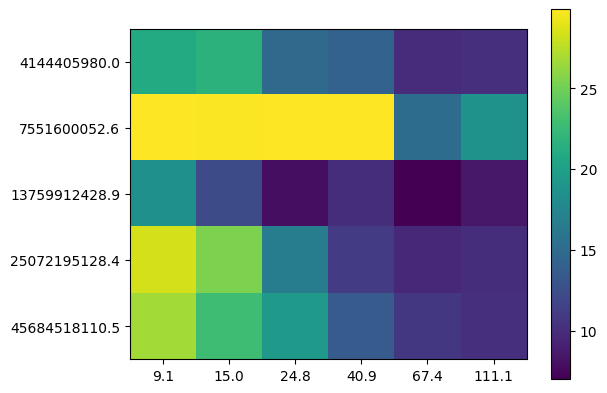

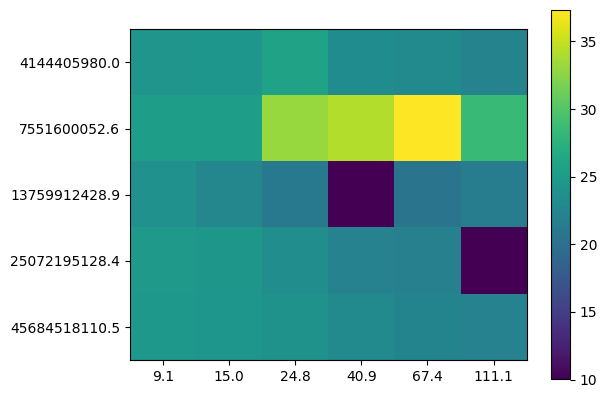

CPU times: user 1d 13h 51min 7s, sys: 23min 9s, total: 1d 14h 14min 17s
Wall time: 11h 23min 48s


In [12]:
%%time
reff_2d = []
density_2d = []
count = 0
for i in uncertainties:
    reff_1d = []
    density_1d = []
    for j in scales:
        count += 1
        print(str(count) + " out of " + str(len(uncertainties)*len(scales)))
        print("------uncertainty", i, "scale", j, "-------")
        reff, density = retrieve(i, j)
        reff_1d.append(reff)
        density_1d.append(density)
    reff_2d.append(reff_1d)
    density_2d.append(density_1d)

rounded_uncertainties = np.round(uncertainties, 1)
rounded_scales = np.round(scales, 1)
img = py.imshow(reff_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()

img = py.imshow(density_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()


In [17]:
reff_2d[1][0]
uncertainties[0]
# scales[2]

3943